In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras

print('numpy version', np.__version__)
print('tensorflow version', tf.__version__)
print('keras version', keras.__version__)

numpy version 1.20.3
tensorflow version 2.5.0
keras version 2.5.0


- numpy 1.20과 tensorflow 2.4는 궁합이 좋지 않다. 문제가 생긴다면 numpy를 1.19로 downgrade 할 필요가 있다.

```
!pip install numpy==1.19.5
```

- tensorflow 2.6을 설치하면 keras 2.7 이 설치될 수 있다. 역시 tensorflow 2.6과 문제가 발생할 수 있다.
```
!pip uninstall keras
pip install keras==2.6
```

<a href="https://colab.research.google.com/github/k5yi/econ2005/blob/master/notebooks/02TrainingMLPKeras.ipynb">
  <img src="https://img.shields.io/badge/%EC%84%9C%EA%B0%95%EA%B2%BD%EC%A0%9C-2%20Traning%20DNN%20with%20Keras -crimson?labelColor=navy&logo=googlecolab&logoClolor=crimson" align='left'/>
</a> <br><br>

## 모형의 구성과 실행

- 모형은 layer들을 연결하여 구성하고, 기본적으로 모든 layer 들은 densely connected 되어 있다. 즉, 각 layer의 unit 들은 인접 layer의 모든 unit들과 연결되어 있다.


- Tensorflow 2를 이용한 방법을 소개한다. Pytorch implementation은 자료의 정리부터 추정까지 Tensorflow와는 많이 다르다.

- Sklearn implementation과 비교해 보면 `compile` 단계가 추가되어 있다. 
([keras](https://keras.io/api/models/model_training_apis/), [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)) 참고


- sklearn Logistic regression
```python
model = LogisticRegression(regularization, solver)
model.fit(data)
```


- tensorflow.keras.models
```python
model = tf.keras.Model(input/hidden/output layers)
model.compile(optimizer, loss)
model.fit(data)
```

- machine learning algorithm은 주어진 목적함수를 최적화하기 위한 algorithm으로 손실함수의 선택은 모형의 선택과 다를 수가 없다.
- 반면 neural network 모형은 스스로 '최적 모형'을 선택하므로 machine learning algorithm과는 다르게 모형에게 목적을 알려주어야 한다. compile의 가장 중요한 keyword이다.


- ML에서 최적화과정은 local optimal solution을 계산하므로 수렴이 전제가 된다면 모형설정에 특별히 연구자의 경험이 개입될 여지가 없다. 모형에 따라 사용할 수 있는 algorithm들에 제한이 있으므로 이 점만 주의하면 된다.
- NN에선 훈련과정에서 backpropagation이란 일반화된 방법을 사용하기 때문에 최적화 algorithm의 선택은 수렴여 부보다는 훈련시간과 모형의 성과에 큰 영향을 미친다.


- Compile에선 최적화 algorithm인 `optimizer`와 손실함수 `loss`를 필수적으로 지정해야 하며, 지표 `metrics`를 지정해 훈련 성과를 평가할 수 있다.

### Model - Layers

- 앞서 살펴본바와 같이 layer는 multivalued multivariable 함수이다.


1. input layer
  - DNN에선 2차원 자료만 다룰 수 있다. input layer에서 `shape`으로 feature의 수를 지정한다.


2. hidden layers, output layer
  - layer의 neuron 수와 neuron의 activation function을 지정

In [2]:
nobs, n_features = 3, 2
x = np.arange(nobs*n_features).reshape(nobs, n_features)

hidden_layer = tf.keras.layers.Dense(units=4, input_dim=2)

print(x)
print(hidden_layer(x))  # output of the hidden layer
print(hidden_layer.activation(x))

[[0 1]
 [2 3]
 [4 5]]
tf.Tensor(
[[ 0.83481646  0.7642493  -0.6178727  -0.32355452]
 [ 3.4524598   3.146194   -1.0249205   0.11266279]
 [ 6.070103    5.5281386  -1.4319682   0.5488801 ]], shape=(3, 4), dtype=float32)
[[0 1]
 [2 3]
 [4 5]]


- 모형은 layer의 입력을 지정하는 방법으로 layer를 연결하고, input layer와 output layer를 이용하여 완성한다.
- 다른 구성 방법은 나중에 자세하게 다룬다.

In [3]:
inputs = tf.keras.Input(shape=2, name='input')
neuron = tf.keras.layers.Dense(units=1, activation='sigmoid', name='neuron')(inputs)

model = tf.keras.Model(inputs, neuron, name='perceptron')
print(inputs)
print()
print(neuron)
print()
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name='input'), name='input', description="created by layer 'input'")

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='neuron/Sigmoid:0', description="created by layer 'neuron'")

Model: "perceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
neuron (Dense)               (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


### Compile

- 분석목적에 맞게 훈련에 사용할 최적화 algorithm을 완성

```python
compile(optimizer='rmsprop', loss=None)
```

In [4]:
model.compile(loss='mean_squared_error')
print('optimizing algorithem: ', model.optimizer)
print('loss function: ', model.loss)

optimizing algorithem:  <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x000002AD2AAD0640>
loss function:  mean_squared_error


### Fit

- 훈련에 표본을 어떻게 사용할 것인지에 대한 세부 내용을 지정

```python
model.fit(features, target, epochs=1, verbose='auto')
```

### Evaluation

- test data의 손실함수 값과 metrics 값을 구한다.

```python
loss, *metrics = model.evaluate(x, y, verbose=1)
```

## Machine learning과 Deep learning Algorithms


```python
from tf.keras import Input, Model
from tf.keras.layers import Dense, Dropout, AlphaDropout
```


### Logistic regression

```python
inputs = Input(shape=(3,))
output = Dense(1, activation='sigmoid')(inputs)
logit = Model(inputs, output)

logit.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
logit.fit(x, y, epochs=1, verbose=1)
```

### Linear regression

```python
inputs = Input(shape=(3,))
output = Dense(1, activation='linear')(inputs)
ols = Model(inputs, output)

ols.compile(optimizer='sgd', loss='mse')
```

### simple neural network

```python
inputs = Input(shape=(3,))
hidden = Dense(50, activation='relu')(inputs)
output = Dense(1, activation = 'sigmoid')(hidden)
ann = Model(inputs, output)

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
```

### deep deep neural network

```python
n_layers = 4

inputs = Input(shape=(3,))
x = Dense(64, activation='relu')(inputs)
x = Dropout(0.4)(x)

for layer in range(n_layers - 1): 
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

dnn = Model(inputs, output)
```

## Vanila Neural Network - XOR

- 이론적으론 2개의 neuron과 1개의 hidden layer으로 구성한 network은 xor 문제를 완벽하게 해결할 수 있다.
- ML과 다르게 iteration의 기준이 tolerence가 아니라 batch_size와 epoch으로 결정되는 iteration 횟수이므로 학습을 충분히 시키거나, 혹은 neuron의 수를 늘려 해결하기도 한다.

In [5]:
import numpy as np
from sklearn.datasets import make_blobs

class xor():
    
    def __init__(self, cluster_per_class=2, n_class=2):
        self.cluster_per_class = cluster_per_class
        self.n_class = n_class
        self.n_cluster = self.cluster_per_class*self.n_class
        
    def centers(self):
        
        center_points, step = np.linspace(0, 2*np.pi, self.n_cluster, 
                                          endpoint=False, retstep=True)
        center_points = center_points + step/2
        center_points = np.array([(np.cos(x), np.sin(x)) for x in center_points])
        
        return center_points
    
    def data(self, points_per_cluster=1, cluster_std=0.2, random_state=None):
        
        centers_ = self.centers()
        n_samples = self.n_cluster*points_per_cluster
        
        x, y = make_blobs(n_samples=n_samples, n_features=2, 
                      centers=centers_, cluster_std=cluster_std,
                      shuffle=True, random_state=random_state)
        
        for i in range(self.n_class):
            y = np.where(y % self.n_class==i, i, y)
            
        return x, y

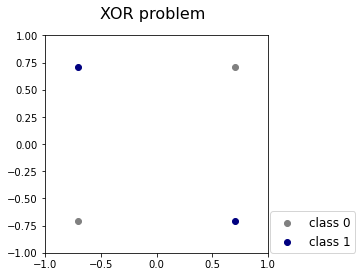

In [6]:
fig, ax = plt.subplots(figsize=(4,4))

n_class = 2
x, y = xor().data(cluster_std=0)
colors = ('gray', 'navy')

for c in range(n_class):
    ax.scatter(x[y==c][:, 0], x[y==c][:, 1],
               c=colors[c], label="class "+str(c))
ax.legend(loc=(1.01,0), fontsize=12)
ax.set(xlim = [-1, 1], ylim=[-1,1])
plt.suptitle("XOR problem", fontsize=16);

In [7]:
from sklearn.preprocessing import StandardScaler

tf.random.set_seed(42)

x = StandardScaler().fit_transform(x)

inputs = tf.keras.Input(shape=(2,), name='input')
hidden_layer = tf.keras.layers.Dense(units=2, 
                                     activation='sigmoid', 
                                     name='hidden_layer')(inputs)
outputs = tf.keras.layers.Dense(units=1, 
                                activation='sigmoid', 
                                name='output')(hidden_layer)
model = tf.keras.Model(inputs=inputs, 
                       outputs=outputs, 
                       name='ANN')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='binary_accuracy')
hist = model.fit(x, y, epochs=1000, verbose=0)
loss, acc = model.evaluate(x, y, verbose=0)

print(model.summary())

print()
print('loss =', round(loss, 2), ', accuracy =', acc)

Model: "ANN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
hidden_layer (Dense)         (None, 2)                 6         
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None

loss = 0.54 , accuracy = 1.0


In [8]:
pred = model.predict(x)
#pred = np.argmax(pred, axis = 1)
label = y

print("prediction: ", pred)
print("class: ", label)

prediction:  [[0.6007451]
 [0.3979302]
 [0.5468373]
 [0.4084293]]
class:  [1 0 1 0]


## Digit image data

### Logistic regression vs Multi-layer Perceptron

- Binary clssification 문제인 경우 activation function이 sigmoid 함수인 perceptron은 그 구조가 logistic regression 모형과 완전히 동일하다.


- Multi-class classification 문제는 multinomial regression과 MLP가 다른 방식으로 접근한다.
 - Multinomial의 경우 OVO이나 OVR 이므로 9개의 서로 독립적인 binary classification에서 64차원의 weight vector로 추정한 결과를 begging 과정을 거쳐 사용한다.
 - MLP 역시 10개의 64차원의 weight vector와 bias를 사용하지만 softmax의 함수값이 손실함수에 직접 사용되므로 모든 weight는 서로 연관되어 있다.
 - 표본 두 개의 label을 서로 바꾸면 multinomial의 decision boundary 중 7개는 영향을 받지 않지만 MLP의 경우에는 모든 boundary가 영향을 받는다. 

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()

print('feature shape: ', digits.data.shape)
print('target shape: ', digits.target.shape)
print()
print('target names: ', digits.target_names)
print('features: \n', digits.data[0,:])

feature shape:  (1797, 64)
target shape:  (1797,)

target names:  [0 1 2 3 4 5 6 7 8 9]
features: 
 [ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


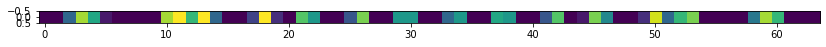

In [10]:
plt.figure(figsize=(14,1))
plt.imshow(digits.data[0,:].reshape(1,-1));

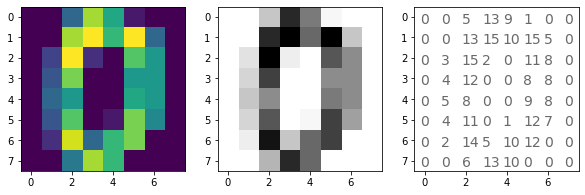

In [11]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10,6))

ax0.imshow(digits.data[0,:].reshape(8,8))
ax1.imshow(digits.data[0,:].reshape(8,8), cmap="Greys")
ax2.imshow(np.ones((8,8))*0, cmap="Greys")

for i in range(8):
    for j in range(8):
        ax2.text(i-.2, j+.3, digits.data[0].reshape(8,8)[j,i].astype(int), c="dimgray", fontsize=14)


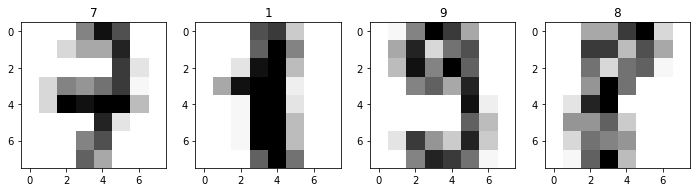

In [12]:
fig, ax = plt.subplots(1,4,figsize=(12,4))

ax = ax.flatten()
for i, num in enumerate(np.random.randint(0,100,4)):
    ax[i].imshow(digits.data[num,:].reshape(8,8), cmap="Greys")
    ax[i].set_title(digits.target[num], fontsize=12);

In [13]:
n_train_samples = int(0.6*len(digits.data))

x_train, y_train = digits.data[:n_train_samples, :], digits.target[:n_train_samples]
x_test, y_test = digits.data[n_train_samples:, :], digits.target[n_train_samples:]

### Perceptron

In [14]:
inputs = tf.keras.Input(shape=(64,), name='input')

# multi-class classification
outputs = tf.keras.layers.Dense(units=10, 
                                activation='softmax', 
                                name='output')(inputs)

logit = tf.keras.Model(inputs=inputs, outputs=outputs, name='logit')

print(logit.summary())

logit.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

logit_hist = logit.fit(x_train, y_train, epochs=100, verbose=0)

loss, acc = logit_hist.history['loss'][-1], logit_hist.history['accuracy'][-1]
print()
print('loss =', round(loss, 2), ', accuracy =', acc)

Model: "logit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64)]              0         
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________
None

loss = 0.02 , accuracy = 0.997217059135437


In [15]:
loss, acc = logit.evaluate(x_test, y_test, verbose=0)
print('loss =', round(loss, 2), ', accuracy =', acc)

loss = 0.48 , accuracy = 0.9082058668136597


### Multi-layer Perceptron

- 일반적으로 적당한 깊이의 neural network과 perceptron 사이에는 performance에 큰 차이가 있다. Hidden layer가 증가하면서 fitting이 좋아지지만 지나치면 overfitting의 가능성이 높아진다.


- 추정해야 할 모수의 수는 logistic regression에선 585개, perceptron에선 650개, 아래 MLP의 경우 2,410개로 증가한다. 표본수 1,797개 보다 많다. 

In [16]:
inputs = tf.keras.Input(shape=(64,), name='input')

hidden_layer = tf.keras.layers.Dense(units=32,
                                     activation='sigmoid', 
                                     name='hidden_layer')(inputs)
# multi-class classification
outputs = tf.keras.layers.Dense(units=10, 
                                activation='softmax', 
                                name='output')(hidden_layer)

mlp = tf.keras.Model(inputs=inputs, outputs=outputs, name='mlp')

print(mlp.summary())

mlp.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics='accuracy')

mlp_hist = mlp.fit(x_train, y_train, epochs=100, verbose=0)

loss, acc = mlp_hist.history['loss'][-1], mlp_hist.history['accuracy'][-1]
print()
print('loss =', round(loss, 2), ', accuracy =', acc)

Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64)]              0         
_________________________________________________________________
hidden_layer (Dense)         (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 2,410
Trainable params: 2,410
Non-trainable params: 0
_________________________________________________________________
None

loss = 0.01 , accuracy = 1.0


In [17]:
loss, acc = mlp.evaluate(x_test, y_test, verbose=0)
print('loss =', round(loss, 2), ', accuracy =', acc)

loss = 0.25 , accuracy = 0.924895703792572


### Data augmentation

- Test set의 숫자들의 위치가 training set과 다른다면 모형의 예측력이 영향을 받는다.
- 분류는 각 위치의 pixel이 어떤 특징을 갖는가에 따라 결정되므로 위치 정보에 대한 '오류'는 예측을 어렵게 한다.
- 모형을 크고 깊게 만들어 performance를 어느정도 증가시킬 수 있지만 digit image의 분류에선 별다른 차이가 없다.
- 이런 특징을 이용하여 image 표본의 크기와 다양성을 증가시키는 용도로 사용하기도 한다.

In [18]:
def shift_image(im):
        
    squared = im.reshape(-1,8,8).copy()
    idx = [7]+list(range(7))
    
    squared[::2] = squared[::2,:,idx]
    
    return squared.reshape(-1,64)

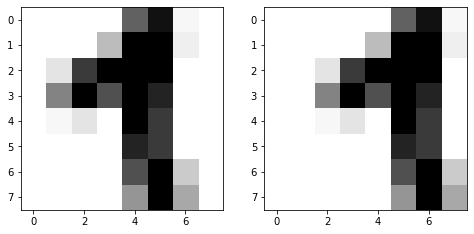

In [19]:
x_test_shift = shift_image(x_test)

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))

k = np.random.choice(range(0, len(x_test), 2))
ax0.imshow(x_test[k,:].reshape(8,8), cmap=plt.cm.Greys)
ax1.imshow(x_test_shift[k,:].reshape(8,8), cmap='Greys');

In [20]:
loss, acc = logit.evaluate(x_test_shift, y_test, verbose=0)
print('loss =', round(loss, 2), ', accuracy =', acc)

loss = 1.86 , accuracy = 0.731571614742279


In [21]:
loss, acc = mlp.evaluate(x_test_shift, y_test, verbose=0)
print('loss =', round(loss, 2), ', accuracy =', acc)

loss = 1.02 , accuracy = 0.7510431408882141


- 사건집합에 포함되지 않은 사건에 대해서도 높은 신뢰도의 예측을 한다.
- 자주 언급되는 deep learning의 한계이다.


predict: 
 [[1.73791870e-02 1.08084685e-04 9.06426180e-03 3.00417817e-03
  7.92160869e-01 6.70779403e-03 8.16178857e-04 1.65139303e-01
  8.43607922e-05 5.53585403e-03]]

prediction:  4


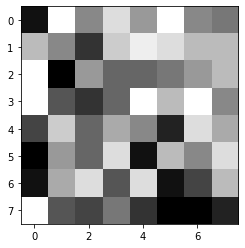

In [22]:
test_x = np.random.randint(0, 16, (1,64))
plt.imshow(test_x.reshape(8,8), cmap="gray")

y_pred = mlp.predict(test_x)
print()
print('predict: \n', y_pred)
print()
print('prediction: ', np.argmax(y_pred))

## ANN 모형의 환경설정

- activation, loss, updating rule, epoch, unit과 layer의 수의 선택은 자료와 분석 목적에 영향을 많이 받는다.


- Palmer Penguins 자료를 이용하여 각각의 기본적인 특성을 살펴본다.


<img src="https://github.com/allisonhorst/palmerpenguins/blob/master/man/figures/lter_penguins.png?raw=true" width=500>

source: @allison_horst https://github.com/allisonhorst/penguins

### Palmer Penguins dataset

- 이 자료는 2007 - 2009 사이에 Dr. Kristen Gorman가 수집한 것으로 세 종류의 남극펭귄에 대한 344개 관찰값이다.
  - species: penguin species (Chinstrap, Adélie, or Gentoo)
  - culmen_length_mm: culmen length (mm)
  - culmen_depth_mm: culmen depth (mm)
  - flipper_length_mm: flipper length (mm)
  - body_mass_g: body mass (g)
  - island: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
  - sex: penguin sex
<br><br>
- Chinstrap의 경우 단일 feature로는 거의 구분이 불가능하지만, 두 feature를 동시에 고려하면 상당한 수준까지 분리가 가능하다.
<br><br>

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns

penguins = sns.load_dataset("penguins")
penguins.info()

penguins.dropna(inplace=True)

target = penguins.pop('species')
features = penguins

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [24]:
penguins.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Torgersen,39.3,20.6,190.0,3650.0,Male


In [25]:
print(target.unique())
print(features.island.unique())
print(features.sex.unique())

['Adelie' 'Chinstrap' 'Gentoo']
['Torgersen' 'Biscoe' 'Dream']
['Male' 'Female']


### preprocessing

- missing value는 모두 삭제


- island는 OneHotEncoder로 dummy처리
- sex는 boolean으로 dummy 처리


- Target은 one-hot encoding을 사용하여 loss 로 categorical_crossentropy를 사용
 - LabelEncoder를 적용하면 loss는 sparse_categorical_crossentropy를 사용
 - 연속변수들은 모두 standardize


- train, test data를 구분


- Dataset object로 변환


- 자료처리를 할 때는 train/test dataset 구분 후에 train dataset에 적용한 process를 test dataset에 동일하게 적용해야 한다.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

target_ohe = OneHotEncoder(sparse=False)
target = target_ohe.fit_transform(target.to_numpy().reshape(-1,1))

features['sex'] = (features.sex == 'female').astype(int)

island = features.pop('island')
island_ohe = OneHotEncoder(sparse=False, drop='first')
island = island_ohe.fit_transform(island.to_numpy().reshape(-1,1))

features = np.c_[features, island]

### Dataset Pipleline

- [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat) 을 이용한 자료 준비
- Tensor 자료를 그대로 사용하기도 하지만 표본이 크거나 여러가지 전처리가 필요할 떄는 dataset instance로 가공하여 사용해 보자.

- Dataset API는 GPU 사용의 효율성을 높이고, 복잡한 전처리 과정을 간단히 할 수 있다.
  - GPU의 data 입력지연
  - image나 text 분석에 필요한 전처리


- 관련공식문서: [data.Dataset](https://www.tensorflow.org/guide/data), [model.fit](https://www.tensorflow.org/guide/keras/train_and_evaluate#training_evaluation_from_tfdata_datasets)


#### from_tensor

```python
dataset = tf.data.Dataset.from_tensor(tensors, name=None)
dataset = tf.data.Dataset.from_tensor_slices(tensors, name=None)
```

- `from_tensor`는 표본 전체를 하나의 원소로 갖는 dataset을 만들고,
- `from_tensor_slices`는 표본을 `input.shape[0]`개로 나눈, 즉 표본별 feature로 구분한 2차원 구조로 dataset을 만든다.
- 아래 사이트로 가보면 시각적인 설명과 함께 이해가 쉽게 정리되어 있다.

> from_tensors makes a dataset where each input tensor is like a row of your dataset, and from_tensor_slices makes a dataset where each input tensor is column of your data; so in the latter case all tensors must be the same length, and the elements (rows) of the resulting dataset are tuples with one element from each column. [stack overflow user1488777](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic)


#### shuffle과 batch


```python
dataset.shuffle(buffer_size, seed=None, reshuffle_each_iteration=None)
dataset.batch(batch_size, drop_remainder=False)
```

- shuffle은 각 epoch 마다 training dataset을 shuffle
- buffer_size는 자료를 섞기위해 한번에 memory에 올리는 표본의 크기이다.
- buffer_size는 크면 클 수록 좋다고 하지만 사용하는 PC의 사양과 적당히 타협한다.
- buffer_size=len(dataset)이 기본이라고들 한다.


- shuffle이 자료를 섞을 때는 한번에 (자료를 입력한 순서대로) buffer_size 만큼의 자료를 가져와 섞는 작업을 반복한다.
- 만일 표본 일부분에 특정 자료들이 뭉쳐있다면 일부 표본이 분리된 채로 남아있어 추정결과의 자료에 대한 의존성이 높아질 수 있다.
- shuffle과 buffer_size는 overfitting을 감소시키는데 도움이 된다.


- 여기서 batch는 batch_size가 아니라 전체 표본을 몇개의 batch로 나누어 사용할 것인가를 지정한다.
- fit의 선택 중 하나인 shuffle은 표본을 관찰값 단위로 섞는 것이 아니라 batch_size로 나눈 batch를 섞어서 사용할 것인 가를 결정하는 keyword이다.


#### repeat

```
dataset.repeat(count=None, name=None)
```

- `count` 횟수만큼 반복한 dataset을 출력으로 얻을 수 있다.

In [27]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

penguin_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
penguin_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [28]:
penguin_train.cardinality().numpy()

223

### Layers

- 인공망 모형은 다수의 layer로 구성되고, 각 layer는 함수 기능을 한다.

- [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers)
- Tensorflow Dense로 만든 모든 layer는 fully connected 되어 있다.


```python
tf.keras.Input(
    shape=None, batch_size=None, name=None, dtype=None, sparse=None, tensor=None,
    ragged=None, type_spec=None, **kwargs
)


tf.keras.layers.Dense(units, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros', kernel_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    bias_constraint=None, **kwargs
)

tf.keras.layers.Dropout(
    rate, noise_shape=None, seed=None, **kwargs
)

tf.keras.layers.BatchNormalization(
    axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones', beta_regularizer=None,
    gamma_regularizer=None, beta_constraint=None, gamma_constraint=None, **kwargs
)
```

### input layer와 input data

- input layer에는 activation이 없으며 원자료를 다음 단계로 전단하는 기능이므로 독립된 layer로 볼 수 없다.
- tensor는 다차원 ndarray으로 deep learning의 기본 입력자료 형식으로, 입력 layer에서는 input tensor의 shape을 지정한다.
- Dense layer는 activation function을 제일 마지막 축에만 적용하므로 input shape (batch_size, d1, $\cdots$, d-2, d-1)에 대해 output shape은 (batch_size, d1, $\cdots$, d-2, n_units)가 된다.


- 모형에 따라 각 축에 다른 이름으로 부른다. 각 모형마다 축을 따라 다른 처리과정을 적용하므로 입력자료를 준비할 때 주의해야 한다.

  - DNN: (batch_size, *width, height, depth,* features)
  - NLP: (batch_size, length, embedding dimension)
  - RNN: (batch_size, timesteps, features)
  - CNN: (batch_size, width, height, depth (혹은 channel size))

<img src="https://www.tensorflow.org/guide/images/tensor/shape2.png" width="200">

[source](https://www.tensorflow.org/guide/tensor#about_shapes)

- Keras는 임의의 batch size를 다룰 수 있으므로 batch size는 Dataset instance나 fit 단계에서 지정 <br>
input_size = (2,)로 입력하면 Keras는 (None, 2)로 해석 <br>
input shape은 첫 번째 축(0)의 값을 생략한 **표본 하나**의 shape, `x[0].shape`과 동일하다.
<br><br>

- 최적화 과정에서 사용하는 batch size는 `fit` method에서 지정할 수 있으며, input layer에서 필요하다면 `batch_input_shape`이나 `batch_shape`으로 지정할 수 있다. 


- Tensorflow DNN의 dense layer에선 1차원 feature만 처리할 수 있다.
- Image와 같이 자료의 구조가 복잡하면 `Fatten()`으로 1차원으로 바꿔서 입력한다.

```python
tf.keras.Input(shape=(192,))

tf.keras.Input(shape=(8, 8, 3))
tf.keras.layers.Flatten()
```
- input layer는 실제로는 layer가 아니므로 보통은 code에서 생략하고 첫 hidden layer에서 input size를 입력

### input layer

- input는 다음 세가지 방법으로 처리할 수 있다.

1. 처음 layer를 input layer로 처리
2. input을 tensor로 처리하여 functional api에서 사용할 수 있도록 한다.
3. 명시적으로 input layer를 만든다. Sequential api에서만 사용할 수 있다.

#### input layer를 암묵적으로 지정

- Sequential API에서는 input shape을 포함하는 layer를 input layer로 해석하여 input layer object를 생성 <br>
- Input이 1차원 array일 경우 (one-dimensional array of features) `input_dim` 으로 feature의 수를 직접 입력할 수 있다.<br>
`input_shape=(64,)`와 같이 tuple로 지정하거나 간단하게 `input_dim = 64`

```python
tf.keras.layers.Dense(units, input_shape=(64,))
tf.keras.layers.Dense(units, input_dim=64)
```

#### input tensor

- input을 tensor로 처리하여 functional api에서 입력으로 사용

```python
tf.keras.Input(shape=64, batch_size=None)
tf.keras.layers.Input(shape=64, batch_size=None) #alias
```

#### InputLayer

- input layer를 직접 생성하여 sequential api에서 사용할 수 있다.
- 위 두 방법을 사용하면 처리과정에서 InputLayer가 생성된다.
- Sequential api를 사용하면서 batch_size를 입력단계에서 지정해야 할 때 사용할 수 있다.
- 사용하는 code를 거의 찾아볼 수 없다.

```python
tf.keras.layers.InputLayer(input_shape=(64,), batch_size=None)
```

#### batch_size

- batch_size는 보통 fit stage에서 지정하지만 `input_shape`로 input 단계에서 지정할 수 있다.
- input에서 batch_size를 지정하면 fit 에서 수정할 수 없다.
- input_shape에서 `None`은 구체적인 shape 지정 없이 placeholder역할을 한다.

In [29]:
# batch the input to use Dataset
penguin_train = penguin_train.shuffle(buffer_size=10_000).batch(16)
penguin_test = penguin_test.batch(16)

In [30]:
tf.keras.layers.Dense(4, input_dim=7)

In [31]:
inputs = tf.keras.Input(shape=7, name='input')
inputs

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'input')>

In [32]:
tf.keras.layers.InputLayer(input_shape=7,)

### hidden layers and units

- Layer의 입력이 2차원 tensor라면, layer의 input shape은 (batch_size, d)이 된다.


- 각 unit의 weight vector는 (d,), 전체 layer의 weight matrix의 shape은 (d, units)이다.
- 마찬가지로 각 unit의 bias vector의 shape은 (d,)가 된다.


- 각 layer는 입력과 weight를 곱해 shape이 (batch_size, units)인 output을 다음 단계로 내보낸다.
- 따라서 각 layer의 입력은 전단계의 unit수 (첫 번째 layer에선 feature의 수)이다.


- Softmax를 hidden layer의 activation function으로 사용할 때는 충분히 주의해야 한다.
  - 각 unit을 상호의존적으로 만들어 버린다.
  - 특히 input 중 하나의 값을 작게 만들면 다른 값이 커지게 되므로 오차가 커질 수 있다.
  
  
- `tf.keras.layers`의 객체들은 `get_weights()` method를 포함하고 있다.
- `get_weights()`로 layer의 weight를 list로 저장하고 `set_weight()` method로 초기 weight를 지정할 수 있다.

In [33]:
x = np.array([[1,2,3,4]])

print(tf.keras.layers.Dense(2, 'relu'))
y = tf.keras.layers.Dense(2, 'relu')(x)
print(y)

tf.Tensor([[1.7245531 0.       ]], shape=(1, 2), dtype=float32)


In [34]:
hidden = tf.keras.layers.Dense(4, 'relu', name='hidden_layer')(inputs)
print(hidden)

KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='hidden_layer/Relu:0', description="created by layer 'hidden_layer'")


### output layer

- Output layer의 기능은 hidden layer와 완전히 동일하며 output을 예측값으로 사용한다.
- Output layer의 activation 함수는 결과에 큰 영향을 미치므로 주의해서 선택한다.


- Regression 에선 output layer를 하나의 unit으로 구성하고 선형함수를 activation으로 사용
- 분류문제에선 output layer의 unit의 수를 class의 수와 같게 사용하며 sigmoid나 softmax로 각 class의 확률을 예측


- Multi-class classification에서 softmax 이외의 함수를 사용하면 output layer의 각 unit에서 독립적으로 계산이 이루어지므로 모형의 performance가 많이 떨어진다.

In [35]:
# class가 3개 이므로 적합하지 않다.
tf.keras.layers.Dense(1, 'sigmoid')(y)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.19140801]], dtype=float32)>

In [36]:
# 각 class에 대한 확률로 해석하기 어렵다.
tf.keras.layers.Dense(3, 'relu')(y)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.      , 1.368885, 0.      ]], dtype=float32)>

In [37]:
# output의 합은 1이다.
tf.keras.layers.Dense(3, 'softmax', name='output_layer')(y)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.3485529 , 0.08421782, 0.5672293 ]], dtype=float32)>

In [38]:
output = tf.keras.layers.Dense(3, 'softmax', name='output_layer')(hidden)
print(output)

KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='output_layer/Softmax:0', description="created by layer 'output_layer'")


### Dropout (layer)

- 간단하고 효과적인 regularization 방법이다.
- 표본에 대한 의존성을 줄여 overfitting문제를 완화하기 위해 사용한다.
- Dense layer의 경우 과거 정보의 생략은 모형의 성능을 과도하게 나쁘게 할 수 있다.

- prediction을 할 때는 dropout layer를 건너뛴다.

#### Dropout

```python
tf.keras.layers.Dropout(rate, noise_shape=None, seed=None)
```

- input 중 `rate`의 비율만큼 0으로 만들어 다음 layer의 입력으로 사용
- input layer와 hidden layer에는 다른 비율을 적용하기도 한다.
  - input layer에는 0.8, hidden layer에는 0.5~0.8 정도를 많이 사용한다.


- dropout rate이 커지면 weight가 커지는 경향이 있다. <br>
지나치게 큰 weight는 network을 불안정하게 만들므로 max_norm을  kernel_constraint에 적용하기도 한다. 크기는 L2가 기준이며 3~4정도를 많이 사용한다.

```python
from tensorflow.keras.constraints import max_norm
tf.keras.layers.Dense(32, kernel_constraint=max_norm(3), bias_constraint=max_norm(3))
```

- Training dataset의 크기가 작으면 overfitting 문제를 완화하기 위해 dropout은 필수적으로 적용할 필요가 있다.

http://www.nextgenvis.eu/publicationfiles/C16-1165.pdf<br>
https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

#### AlphaDropout

- Alpha Dropout은 원래 표본의 평균과 분산을 유지하면서 일부 입력을 제한한다.
- Self-normalizing 기능으로 계산이 빠르고 vanishing gradient문제에서 자유롭다.
- input 바로 다음에 위치시켜 standardization 용도를 겸해 사용하기도 한다.

```python
tf.keras.layers.AlphaDropout(rate, noise_shape=None, seed=None)
```

### Activation functions

- default activation='linear', identity function
- [tf.keras에서 지원하는 activation functions](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
- [Activation function에 대한 설명 및 장단점](https://mlfromscratch.com/activation-functions-explained/#/)


- 회귀분석과 같이 모든 표본의 편차의 절대적인 크기가 문제가 되는 경우에는 선형함수, <br>
범주 구분을 위한 상대적인 크기가 중요한 분류모형에선 sigmoid나 softmax를 사용한다.<br>
ReLU는 RNN을 제외한 MLP나 CNN 등 대부분의 모형과 상성이 좋은 것으로 알려져 있다.


1. binary step function
 - class가 둘인 문제에만 적용이 가능
 - tensorflow에서 제공하는 최적화 algorithm과는 같이 사용하기 어렵다.


2. **Linear function**
 - 선형함수는 입력값들의 기여도를 구분하지 못하므로 hidden layer에는 잘 사용하지 않는다.
 - Regression 모형의 output layer에 주로 사용한다.
 - 어떤 layer의 조합이던 2개의 layer로 표시할 수 있다.

3. **sigmoid/logistic**
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$
 - smooth한 gradient값을 갖는다.
 - 함수의 범위는 $[0,1]$


4. **tanh / Hyperbolic Tangent**
$$\tanh x = \frac{e^x-e^{-x}}{e^x+e^{-x}}$$
 - 함수의 범위가 $[-1,1]$인 것을 제외하면 sigmoid와 비슷한 성질


- Varnishing Gradient
 - 가중값을 update할 때 적용하는 backpropagation은 chain rule
 - sigmoid 함수에서 절대값이 가장 큰 도함수는 0.25, tanh의 경우 1이므로 hidden layer가 길어질수록 update가 어려워짐

5. **ReLU** (Rectified Linear Unit)
$$\text{ReLU}(x)= \left\{
\begin{array}{ll}
\alpha x & \text{if } x \ge 0 \\
0 & \text{if } x < 0
\end{array}
\right.
$$
 - $a \cdot x \text{ if } x \ge 0, 0 \text{ if } x \le 0$
 - backpropagation에서 vanishing gradient 문제가 없다.
 - computationally efficient (수렴속도가 빠르다)
 - 선형으로 보이지만 backpropagation이 가능한 비선형 함수이다.
 - 0보다 작은 값에서는 backpropagation이 불가능하다.<br><br>
 
 - 각 neuron의 비중을 크게 할 수 있다.
 - sigmoid나 tanh에 비해 random initialization에 덜 민감하다.


6. Leaky ReLU
 - $\max(0.1 x, x)$
 - 모든 값에서 backpropagation이 가능하지만 음의 입력값에 대해선 예측값에 일관성이 없다.


7. parametric ReLU
 - $\max(a \cdot x, x)$
 - 최적 $a$값을 추정한다.
 - 문제에 따라 performance가 다르다.

8. [Swish](https://arxiv.org/abs/1710.05941v1)
 - $x \times \text{sigmoid}(x)$
 - 일부 dataset에서 ReLU에 버금가는 computational efficiency와 performance


9. **Softmax**
$$\text{Softmax} = \frac{e^{x_i}}{\sum_j e^{x_j}}$$
 - softmax는 모든 unit들의 output을 비선형변환을 통해 정규화한다.
 - hidden layer에는 보통 사용하지 않으며 multi-class classification의 output layer에 많이 사용한다.
 
 
10. **SELU(Scaled Exponential Linear Unit)**
$$\text{SELU}(x)=\lambda \left\{
\begin{array}{ll}
x & \text{if } x \ge 0 \\
\alpha e^x - \alpha & \text{if } x < 0
\end{array}
\right.
$$
- weight를 `lecun_normal`로 초기화하면 ouput은 정규화된 형태가 된다.
- 이러한 특징으로 인해 external normlaization을 사용하는 모형에 비해 계산속도가 빠르며 
- vanishing/exploding gradient 문제가 발생하지 않는다.
- Alpha dropout을 사용할 때는 **반드시** SELU를 같이 사용한다.

## Network 구성

- input, hidden, output layer 등을 조합하여 모형을 구성

###  Sequential API

- Layer의 진행 순서로 layer의 list를 만들어 입력
([document](https://keras.io/api/models/sequential/))


```python
model = tf.keras.models.Sequential(
    [
    tf.keras.layers.Dense(units=8, 
                          activation='relu', 
                          input_shape=(64,),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
    ])      
```

- 각 단계를 분리하여 구성하기도 한다.
```python
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=8, activation=tf.nn.relu, input_dim=64))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))
```

- Sequential API는 layer를 공유하거나 둘 이상의 입력이나 출력이 필요한 복잡한 구조의 모형을 만들수 없다.


###  Functional API

- 각 layer의 input은 이전 layer의 결과를 지정하여 사용할 수 있다.
([document](https://keras.io/api/models/model/))


```python
inputs = tf.keras.Input(shape=(8,8))
flatten = tf.keras.layers.Flatten(inputs)
hidden = tf.keras.layers.Dense(units=8, activation='relu')(flatten)    
outputs = tf.keras.layers.Dense(units=10, activation='softmax')(hidden)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
```

- [tf.keras.layers.Concatenate](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)와 [tf.keras.layers.concatenate](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate) 참고

Functional API는 번잡해 보이지만 복잡한 모형을 만들 때 유용하다.

<img src="https://www.tensorflow.org/guide/keras/functional_files/output_52c4dc6fd93e_0.png">

[source](https://www.tensorflow.org/guide/keras/functional)

In [39]:
#inputs = tf.keras.Input(shape=(7,), name='input')
#hidden = tf.keras.layers.Dense(4, 'relu', name='hidden_layer')(inputs)
#output = tf.keras.layers.Dense(3, 'softmax', name='output_layer')(hidden)

model = tf.keras.Model(inputs=inputs, outputs=output, name='functional_api')
model.summary()

Model: "functional_api"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 7)]               0         
_________________________________________________________________
hidden_layer (Dense)         (None, 4)                 32        
_________________________________________________________________
output_layer (Dense)         (None, 3)                 15        
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________


In [40]:
tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=4, activation='relu', input_dim = 7),
    tf.keras.layers.Dense(3, activation='softmax')
                          ], name='squential_api').summary()

Model: "squential_api"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 32        
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 15        
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________


- 아래와 같이 모형을 시각화하려면 다음 package를 설치해야 한다.

```python
!conda install -c anaconda pydot
!conda install -c conda-forge python-graphviz
```

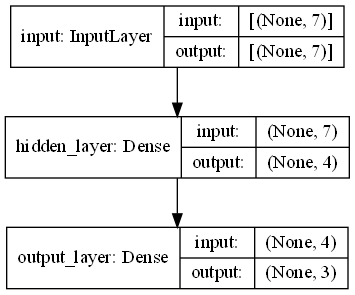

In [41]:
tf.keras.utils.plot_model(model, show_shapes=True)

## compile


- 최적화에 사용할 algorithm과 손실함수 loss function, 성과를 평가할 metrics를 지정한다.<br>
  - 손실함수는 개별표본에서 계산한 값을 표본의 평균으로 표시할 수 있어야 하며
  - 손실함수, metrics, output layer의 activation은 서로 연관되어 있으므로 주의한다.
  - (binary_crossentropy, accuracy, softmax) 와 같이 사용하지 않는다.


- compile을 마친 모형은 후속 과정을 거친 후에도 동일하게 남아있다. 모형을 수정하려면 새롭게 compile 해야한다.


- [손실함수의 종류와 특징에 대한 개략적인 설명](https://neptune.ai/blog/keras-loss-functions#:~:text=The%20sum%20reduction%20means%20that%20the%20loss%20function,returns%20the%20full%20array%20of%20the%20per-sample%20losses.)



### Backward propagation

- Gradient descent를 직접 적용하면 parameter의 수와 layer의 수에 따라 계산해야하는 partial derivative의 수가 기하급수적으로 증가한다.

- 계산문제로 지지부진했던 신경망의 연구는 85년 Rumelhart and Hinton이 backpropagation의 적합성을 증명한 이후로 활성화되었다. Backpropagation은 feed forward 와 backward propagation으로 구분된다.

1. feed-forward propagation 으로 loss 계산
  - 실제 계산에는 사용하지 않는다.
2. 모든 weight에 대한 loss의 편도함수를 계산 
  - 모든 unit의 logit과 output value, 그리고 derivative
3. Neural network의 weight를 gradient descent로 update
  - output layer부터 시작하면 모든 update는 새로 update된 weight만 사용한다.

- Feed-forward propagation은 각 unit에서 주어진 weight로 계산한 activation function의 값을 다음 단계의 입력으로 전달하는 과정
- Backward propagation은 계산한 추정값(estimate)과 실제값(target value)의 차이를 보정해주는 과정으로, 각 입력값이 출력에 미치는 영향을 고려해 가중값을 조정한다.
<br><br>
$$ \frac{\partial L(\mathbf{w})}{\partial \mathbf{w}} =
\frac{\partial L(\mathbf{w})}{\partial a} \times
\frac{\partial a}{\partial z} \times
\frac{\partial z}{\partial \mathbf{w}}$$
<br>
$$
\Delta \mathbf{w} = - s \frac{\partial L(\mathbf{w})}{\partial \mathbf{w}}
$$
<br>
여기서 $a$가 sigmoid 라면 도함수는 $a(1-a)$이므로 다음과 같이 계산할 수 있다.
<br><br>
$$\frac{\partial L(\mathbf{w})}{\partial \mathbf{w}} =
\frac{\partial L(\mathbf{w})}{\partial a} \times a(1-a) \times \mathbf{x} $$

- 흔히 사용하는 activation의 도함수는 계산이 간단하다.

$$\frac{d \sigma (x)}{d x} = \sigma(x) (1-\sigma(x), \quad
\frac{d \tanh (x)}{d x} = 1 - \tanh^2 (x)$$

## compile - optimization algorithm

- 한번의 계산에 사용하는 표본의 크기

1. Gradient descent
  - 전체표본을 이용하여 gradient를 계산
2. Stochastic Gradient Descent
  - 개별 표본에 대해 gradient를 계산 
  - 움직임이 크므로 전역적 극점을 찾을 가능성이 높다
  - 잦은 update로 overshooting 가능성
3. **Mini batch Gradient Descent**

algorithm | step size | batch size
:--| :--: | :--:
GD | s | n
SGD | s/t | 1
BGD | s/b | b


- 곡률에 대한 정보

1. Momentum-based Gradient Descent
2. Nesterov accelerated Gradient Descent
3. Adaptive learning rate
  - Adagrad, **RMSProp**, **Adam**

[침고 블로그](https://towardsdatascience.com/why-gradient-descent-isnt-enough-a-comprehensive-introduction-to-optimization-algorithms-in-59670fd5c096)

### batch size

#### (Batch) Gradient Descent (GD)

- Target $y$와 output $\hat{y}$가 연속적인 변수라고 가정해 보자.
<br>
$$\text{Loss}(\mathbf{w}) = \frac{1}{2n} \sum^n_{i=1} (y_i - \hat{y}_i)^2$$
<br>
$w$가 Loss에 미치는 영향은 gradient로 표시할 수 있다.

$$\nabla_{w_k} \text{Loss} (\mathbf{w})= 
\frac{1}{n}  \sum^n_{i=1} (y_i - \hat{y}_i) 
\left( - \frac{\partial \hat{y}_i}{\partial w_k} \right)$$

- Loss을 감소시키기 위해서는 이 gradient 방향과 반대로 움직여야 한다. 즉,
<br>
$$\text{sign} \left( \Delta w_k \right) = - \text{sign} \left( \nabla_{w_k} \text{Loss} (\mathbf{w}) \right)$$


- update의 scale을 결정하는 learning rate $s$는 $w$와 독립적인 값을 사용한다.
<br>
$$\Delta w_k = - s \nabla_{w_k} \text{Loss} (\mathbf{w})$$
<br>
한편 $ \hat{y}_i = \sigma(\mathbf{w}^\intercal \mathbf{x})$ 이므로
<br>
$$\frac{\partial \hat{y}_i}{\partial w_k} = 
\nabla \sigma(\mathbf{w}^\intercal \mathbf{x})
\times \frac{ \partial \mathbf{w}^\intercal \mathbf{x} }{ \partial w_k  }
= \nabla \sigma(\mathbf{w}^\intercal \mathbf{x}) \times x_{ik}  $$
<br>
따라서
<br>
$$\Delta w_k =   
\frac{s}{n} \times 
\sum^n_{i=1} \left\{ \nabla \sigma(\mathbf{w}^\intercal \mathbf{x}_i) \times (y_i - \hat{y}_i) \cdot x_{ik} \right\}$$

<p style="color:navy; font-size:1.25em; font-weight:bolder">  Gradient method </p>
    
- 여러가지 최적화 algorithm이 있지만 모두 gradient method에 기초한 방법들이다.

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - s_t \nabla f ( \mathbf{w} ) $$

1. Taylor 1차 근사

$$ f(\mathbf{w} + \Delta \mathbf{w} ) 
\approx f( \mathbf{w} ) + \nabla f ( \mathbf{w} ) \cdot \Delta \mathbf{w} $$

2. Cauchy–Schwarz inequality

$$\left\vert \nabla f ( \mathbf{w} ) \cdot \Delta \mathbf{w} \right\vert
\le \left\Vert \nabla f ( \mathbf{w} ) \right\Vert \left\Vert  \Delta \mathbf{w} \right\Vert
$$

3. step size = 1, $\left\Vert \Delta \mathbf{w} \right\Vert$ = 1

$$\left\vert \nabla f ( \mathbf{w} ) \cdot \Delta \mathbf{w} \right\vert
\le \left\Vert  f (\mathbf{w}) \right\Vert
$$

4. Gradient 방향으로 한 단위 움직인다.

$$\Delta \mathbf{w} = \frac{\nabla f ( \mathbf{w} )}{ \left\Vert  \nabla f (\mathbf{w}) \right\Vert }$$

5. 극소화의 경우에는 반대방향으로 움직인다.


$$\Delta \mathbf{w} = - \frac{\nabla f ( \mathbf{w} )}{ \left\Vert  \nabla f (\mathbf{w}) \right\Vert }$$


- $\Delta \mathbf{w}$는 unit vector이므로 실제 계산에는 step size 혹은 learning rate 를 별도로 지정하여 사용한다.

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - s_t \nabla f ( \mathbf{w} ) $$

- Newton-Raphson Method와 같이 곡률정보를 이용하여 step size를 결정할 수 있지만 saddle point와 계산량 대비 효용성 문제로 사용하지 않으며, 아래에서 소개하는 adaptive learning algorithm으로 곡률정보를 반영한다.
- Iteration마다 계산해야하는 모수의 수가 $K^2$ 비율로 증가한다.

$$ \max_{\Delta \mathbf{w}} f(\mathbf{w}+ \Delta \mathbf{w}) - f(\mathbf{w}) $$

#### Stochastic Gradient Descent (SGD)

```python
tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')
```

- Gradient descent에서는 iteration마다 $\text{n_obs}\times \text{n_features}$ 번의 SSR을 계산해야 한다.
- SGD는 전체 표본에서 하나의 표본을 무착위로 추출해 gradient를 계산하고 weight를 update한다. <br>
빈번한 update로 함수값 변화의 분산이 커지므로 local minimum에 고착되는 문제를 피할 수 있지만 overshooting이 발생하기 쉽다.

$$\Delta w_k = s_t \sigma(\mathbf{w}^\intercal \mathbf{x}_i) (y_i - \hat{y}_i) \cdot x_{ik}$$


#### Mini-batch Gradient Descent (MB-GD)

- GD와 SGD의 절충형으로 표본을 $m$개의 덩어리로 나누어 덩어리별로 GD 방법을 적용한다.

$$\Delta w_k = \frac{s}{n_m} \sum^{n_m}_{i=1} \cdot \sigma(\mathbf{w}^\intercal \mathbf{x}_i) (y_i - \hat{y}_i) \cdot x_{ik}$$



- 이상 세 가지 방법들은 gradient의 정보만 사용한다. 즉 목적함수의 곡률은 전혀 고려하지 않으므로 oscillation이 발생하거나 수렴속도가 늦어질 수 있다.

### Adaptive algorithm


#### Momentum

- 지난 iteration에서 사용한 기울기에 대한 정보 $v$를 명시적으로 고려하여 가파른곳에선 step size를 작게, 완만한 곳에선 step size를 크게 한다.

$$ v^t_k = \eta \cdot v^{t-1}_k - s \nabla_k \text{Loss}(\mathbf{w}) \\
\Delta w_k = - v_k$$

- Oscillation과 목적함수가 평평한 부분에서 수렴속도가 늦어지는 문제를 해결


#### Adagrad

```python
tf.keras.optimizers.Adagrad(
    learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07, name='Adagrad')
```

- Update의 크기와 learning rate의 크기를 반비례하도록 설정한다.<br>
upate가 빈번하지 않은 sparse date에 적합하다.

$$ \Delta w_k = - \frac{s}{\sqrt{ \sum_{\tau=0}^t \nabla^2_k \text{Loss}_\tau(\mathbf{w}) + \epsilon}}
\cdot \nabla_k \text{Loss}(\mathbf{w})$$

- Iteration이 반복될 수록 learning rate이 작아져 iteration이 길어지면 의미있는 작업이 어렵다.


#### Adadelta

```python
tf.keras.optimizers.Adadelta(
    learning_rate=0.001, rho=0.95, epsilon=1e-07, name='Adadelta')
```

- Adagrad의 gradient 제곱합이 일정수준 이상 커지지 않도록 제약
<br><br>
$$E_t(\nabla_k \text{Loss})^2 = \rho E_{t-1}(\nabla_k \text{Loss})^2 + (1-\rho) (\nabla_k \text{Loss}_t)^2$$
<br>
Adagrad의 gradient의 합 자리에 평균을 대입하면
<br>
$$ \Delta w^t_k = - \frac{s}{\sqrt{ E_t(\nabla^2_k \text{Loss}_t) + \epsilon}} 
\cdot \nabla_k \text{Loss}_t(\mathbf{w}) $$
<br>
Step size를 지난 update 크기 제곱의 기대값으로 바꾸어 준다.
<br>
$$ \Delta w^t_k = - \frac{\sqrt{ E_{t-1}( \Delta^2 w_k ) + \epsilon } 
}{ \sqrt{ E_t \nabla^2_k \text{Loss}(\mathbf{w}) } + \epsilon}
\nabla_k \text{Loss}(\mathbf{w}) \\
E_{t-1}( \Delta^2 w_k ) = \rho E_{t-2}( \Delta^2 w_k ) + (1-\rho) E_{t-1}( \Delta^2 w_k )$$



#### RMSProp (root mean squared propagation)

```python
tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop')
```

- Adadelta와 유사하게 Adagrad의 learning rate이 급격히 감소하는 문제를 해결하기 위해 고안 <br>
Adadelta의 첫번째 step과 동일하다. (Adadelta와 비슷한 시기에 독립적으로 제안)

$$ \Delta w_k = - \frac{s}{\sqrt{ E_t(\nabla_k \text{Loss})^2 + \epsilon}} \cdot \nabla_k \text{Loss}(\mathbf{w}) \\ 
\\
E_t(\nabla_k \text{Loss})^2 = \rho E_{t-1}(\nabla_k \text{Loss})^2 + (1-\rho) (\nabla_k \text{Loss}_t)^2$$


#### Adaptive Moment Estimation (Adam)

```python
tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
```

- 지난 gradient와 udpate의 크기를 모두 반영하여 error surface의 곡률을 반영 <br>
Adaptive learning algorithm 중 가장 많이 사용하는 algorithm 중 하나이다.
<br><br>
$$ \Delta w_k = - \frac{s}{\sqrt{v_t}+\epsilon} m_t $$
<br>
여기서
<br>
$$\begin{array}{lcl}
m_t = \beta_1 m_{t-1} + (1-\beta_1) \nabla \text{Loss}_t \\
v_t = \beta_2 v_{t-1} + (1-\beta_2) \nabla^2 \text{Loss}_t
\end{array}$$

- 이외에도 Adamax, Ftrl, Nadam 등을 제공하고 있다.


- Learning rate을 customize하려면 tf.keras.callbacks.LearningRateScheduler을 이용 ([참고](https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c))

[참고 블로그](https://ruder.io/optimizing-gradient-descent/)
[참고 블로그](https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/)

### Learning curve

<img src="https://miro.medium.com/max/1163/1*XVFmo9NxLnwDr3SxzKy-rA.gif" width="500"/>

[Algorithm 개괄](https://ruder.io/optimizing-gradient-descent/)

## compile - loss function

- TensorFlow에서 [지원하는 함수](https://www.tensorflow.org/api_docs/python/tf/keras/losses)를 이용하거나 직접 정의해서 사용할 수 있다.<br>

```python
loss = tf.keras.losses.MeanSquaredError()
compile(loss=loss)
```

- Parameter를 지정할 필요가 없을 경우에는 `compile(loss="mse")`형태로 사용하고,<br>
설정이 필요할 경우에는 다음과 같이 함수를 지정하여 사용한다.


1. Loss function as a string
```python
model.compile (loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
```

2. Loss function as an object<br>
loss function 에 parameter를 pass 할 수 있다.
```python
from tensorflow.keras.losses import mean_squared_error
model.compile(loss=mean_squared_error(param=value), optimizer='sgd')
```

3. Custom loss function
```python
def my_loss(y_true, y_pred):
    loss = ...
    return loss
model.compile(optimizer='sgd', loss = my_loss)
```


### Regression

- Target이 연속변수일 경우에는 L2와 L1을 주로 사용한다.<br>
- 분류모형에도 적용할 수 있지만 모형의 성과가 신통치 않다.


- L2와 L1를 손실함수로 사용할 때는 <br>
하나의 unit과 linear activation function으로 output layer구성한다.<br>


1. 'mse' or 'mean_squared_error'<br>
 - L2 loss는 outlier에 민감하게 반응하므로 outlie상대적으로 불리한 점이 있다.<br>
 - Outlier의 비율이 높은 자료의 경우 오히려 바람직할 수 있다.



2. 'mean_squared_logarithmic_error'<br>
 - 편자의 로그값을 극소화<br>
 - Target 자료값의 자료의 범위가 크면서 unscaled target을 사용해야하는 분석에 적합<br>
 - 최종 성과는 MSE로 평가하는 것이 일반적이다.


3. 'mean_absolute_error'<br>
 - 눈에 띄는 ourlier가 포함된 표본에 적합


4. `loss=tf.keras.losses.Huber(delta=0.1)`<br>
 - 자료의 일부는 뭉쳐있고 많은 관찰값들이 퍼져있는 경우 적합하다.<br>
 - Deviation이 $\delta$보다 작은 경우는 MSE, 큰 경우는 MAE를 적용한다.


$$ \text{loss}_\delta (y,\hat{y}) = \left\{
\begin{eqnarray}
&\frac{1}{2} \left( y - \hat{y} \right)^2 & \quad & \text{for} 
\left\vert y - \hat{y} \right\vert \le \delta \\
&\delta \left\vert y - \hat{y} \right\vert -  \frac{1}{2} \delta^2 & \quad & \text{otherwise} 
\end{eqnarray}
\right.$$


5. [Robust loss function](https://towardsdatascience.com/the-most-awesome-loss-function-172ffc106c99)

$$f(x, \alpha, c) = \frac{|\alpha -2|}{\alpha}
\left[
\left\{ 
\frac{ (x/c)^2 }{ |\alpha -2| } + 1
\right\}^{\frac{\alpha}{2}} - 1
\right]$$

<p style="color:navy; font-size:1.25em; font-weight:bolder"> Neural network for regression

- Regression과 관련된 진짜 문제는 neural network이 regression 문제를 해결하는데 적합한 방법인가 하는 것이다.<br>

    
- OLS로 만족할만한 결과를 얻을 수 있다면 neural network을 사용할 이유가 없다.<br>
다만 좀더 정확한 예측이 필요하거나 선형 모형으로 잡아내기 어려운 의미있는 pattern이 있는 변수라면 neural network이 좋은 도구가 될 수 있다.<br>
Neural network 자체를 경제분석에 유용한 도구로 사용하기 위해서는 pattern의 의미에 대해 계속 고민해야 한다.

- 전력수요 같은 변수에 적용한 것을 본적이 있다.<br>
주식 가격같은 경우에는 사례를 많이 찾아볼 수 있지만 그냥 연습이라고 생각하자.<br>

- pros:<br>
예측에 대한 비중이 크다면 적합한 모형이 될 수 있다.<br>
회귀모형의 선택 범위가 넓을 경우 '자동적'으로 모형을 선택한다.
  - 지수나 로그 변환 등의 항을 포함하는 회귀식
  - Ridge, Lasso, ARIMA 와 같이 지정해야 할 모수가 있는 모형
  - feature들 사이에 복잡한 상호작용이 있을 수 있는 경우 (많은 cross term을 포함하는 회귀식) 


- cons:<br>
overfitting 가능성이 많다.

### Classifiction

- 분류문제에선 prediction과 target의 발생 확률을 비교하는 cross entropy와 
- class 사이의 거리를 크게 만드는 hinge loss를 많이 사용한다.


#### Entropy

$$– \sum p_i \times \log p_i, \quad p_i \in [0,1]$$

#### Cross Entropy

$$– \sum y_i \times \log \hat{y}_i, \quad y_i \in \{0, 1\}, \hat{y} \in [0,1] $$

#### Kullback-Leibler  Divergence

$$– \sum y_i \times \log \frac{y_i}{\hat{y}_i}, \quad y_i \in \{0, 1\}, \hat{y} \in [0,1] $$


- Logitstic regression의 likelihood function과 cross entropy는 같은 표현
- Kullback-Leibler  Divergence와 Cross Entorpy의 평균은 단조선형변환

#### rule of thumb

Mean of Cross Entropy | judge
--: | :--
0.00 | Perfect probabilities
< 0.02 | Great probabilities
< 0.05 | On the right track
< 0.20 | Fine
> 0.30 | Not great
> 1.00 | Terrible
> 2.00 | Something is broken

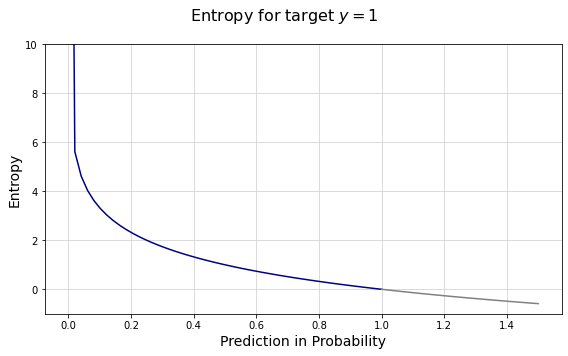

In [42]:
y = 1
y_hat = np.linspace(1e-12,1)
off_lim = np.linspace(1,1.5)

entropy = lambda y, y_hat: - y * np.log2(y_hat)

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(y_hat, entropy(y, y_hat), c='navy')
ax.plot(off_lim, entropy(y, off_lim), c='gray')

ax.set(ylim=[-1, 10])
ax.set_xlabel('Prediction in Probability', fontsize=14)
ax.set_ylabel('Entropy', fontsize=14)

ax.grid(color="lightgray")
fig.suptitle(r"Entropy for target $y=1$", fontsize=16)
fig.tight_layout()

#### hinge loss

- Hinge loss는 SVM의 loss funciton의 변형으로 class 사이의 margin에 의해 결정된다.
- Hinge loss와 cross entropy 의 performance에는 별다른 차이가 없는 것으로 알려져 있다.

$$ \sum \max \left(0, 1-y_i \cdot \hat{y}_i\right), \quad y_i \in \{-1, 1\}$$

#### square hinge loss

$$ \sum \left[ \max \left(0, 1-y_i \cdot \hat{y}_i\right) \right]^2, \quad y_i \in \{-1, 1\}$$



- Cross entropy와 같이 확률로 해석하지 못한다는 '단점'이 있지만 계산 속도가 상대적으로 빠르다.


- Class 사이의 차이 비교할 필요가 없거나 (고양이와 개, 고양이와 다람쥐의 구분처럼 맞고 틀리는 것이 중요한 문제)
- 속도가 문제가 된다면 hinge loss가 좋은 선택이 될 수 있다.

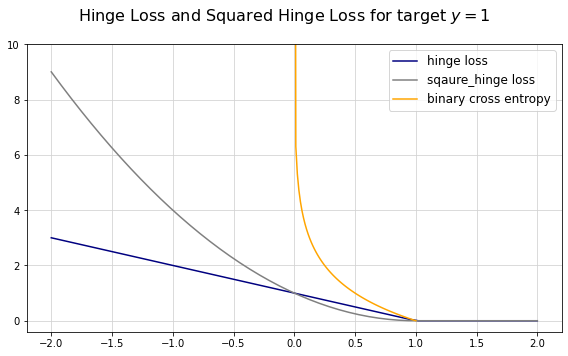

In [43]:
y = 1
y_hat = np.linspace(-2,2)

hinge = np.where(1- y * y_hat < 0, 0, 1- y * y_hat)

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(y_hat, hinge, c='navy', label='hinge loss')
ax.plot(y_hat, hinge**2, c='gray', label='sqaure_hinge loss')
ax.plot(np.linspace(1e-12,1,80), entropy(y, np.linspace(1e-12,1,80)), 
        c='orange', label="binary cross entropy")

ax.set(xlim=[-2.2, 2.2], ylim=[-.4, 10])
ax.grid(color="lightgray")
ax.legend(fontsize=12)
plt.suptitle(r"Hinge Loss and Squared Hinge Loss for target $y=1$", fontsize=16)
plt.tight_layout();

### Binary Classification

1. 'binary_crossentropy'<br>
형태는 logistic regression의 likelihood function과 동일하다.<br>
Target의 값은 0과 1을 사용한다.<br><br>
$$ -y \log \hat{y} - (1-y) \log \hat{y}, \;\; y\in \{0,1\}, \hat{y} \in [0,1] $$
<br>
Binary classification 문제에서는 cross-entropy를 기본으로 사용하며<br>
Keras에서 cross-entropy은 'binary_crossentropy'로 구현한다.
<br><br>
Output layer는 하나의 neuron과 sigmoid activation function을 사용해야 한다.


2. 'hinge' 또는 'squared_hinge'<br>
Hinge loss function은 support vector machine 모형에 적용하기 위해 고안<br>
Target은 $-1$과 $1$, 두 값으로만 구성하며 다른 부호에 대해 더 큰 penalty를 부과한다.<br>
Output layer는 하나의 neuron과 range가 $[-1,1]$인 tanh activation function을 사용해야 한다.

### Multi-Class Classification

- Output layer는 class의 수와 동일한 neuron과 각 범주의 확률을 계산하기 위해서는 softmax activation function을 사용해야 한다.

1. 'categorical_crossentropy'<br>
Cross-entropy의 확장이다.<br>
$$– \sum_c \sum_i 1(y^{\text{pred}}_{ic} = y_{ic}) \times \log \hat{y}_{ic} $$
Target은 one-hot encoding으로 정리해 사용한다.<br>
Tensorflow는 `tf.keras.utils.to_categorical()`으로 one-hot encoding을 지원한다.


2. 'sparse_categorical_crossentropy'<br>
Target의 범주가 많아지면 용량이나 연산관련 문제로 one-hot encoding 사용이 바람직하지 않을 수 있다.<br>
LabelEncoding으로 정리한 target을 사용할 수 있다.


3. 'kullback_leibler_divergence'<br>
각 개별 관찰값의 예측과는 다르게 분포를 근사하는 느낌이다.<br>
'categorical_crossentropy'을 사용할 때와 동일하게 output layer와 target 변수를 정리한다.

### logits, one-hot encoding, labels

- Deep learning에서 logits은 output layer에서 sigmoid나 softmax에 입력하는 자료형태, 즉 $\mathbf{w}\cdot \mathbf{x}+b$를 의미한다.


- output은 loss function의 종류에 따라 one-hot encoding이나 정수 label로 구분해 입력해야 한다. 정수 label의 경우에도 $\{0,1\}$을 사용하는 함수와 $\{-1,1\}$을 사용하는지 함수가 있다.


- Module `tf.nn` 에 logit을 입력으로 받는 loss function이 있다.

```python
tf.nn.sigmoid_cross_entropy_with_logits
tf.nn.weighted_cross_entropy_with_logits
tf.nn.softmax_cross_entropy_with_logits
tf.nn.sparse_softmax_cross_entropy_with_logits
```


- Unbalanced data의 경우 각 class의 비율의 역수를 로그변환한 가중값을 사용하는 것을 볼 수 있다.

## compile - metrics

- MSE나 confusion matrix 관련 값들을 지정하여 모형을 평가할 수 있다.

- 여러 개의 loss function이나 metric을 사용할 때는 list나 dict로 만들어 사용한다.

https://keras.io/api/metrics/<br>
https://www.tensorflow.org/api_docs/python/tf/keras/metrics<br>
https://www.tensorflow.org/api_docs/python/tf/metrics<br>
https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/

In [44]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit

- fit method는 표본으로 손실함수를 극소화하는 weight를 찾는 과정이다.<br>
앞서 선택한 optimization algorithm과 


```python
fit(
    x=None, y=None, batch_size=None, epochs=1, verbose='auto',
    callbacks=None, validation_split=0.0, validation_data=None, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
```

- Fit에서 사용하는 shuffle은 batch 단위로 이루어지기 때문에 결과가 자료의 입력구성에 영향을 받을 수 있다.
- Data point 수준에서 shuffle을 하려면 Dataset instance를 이용한다.
- `class_weight`는 dict, `sample_weight`는 array로 지정하여 사용한다.


- `fit` method는 dict와 유사한 `History` 객체를 return한다. History.history에선 각 epoch별, 그리고 validataion step별로 loss 크기와 metrics 값을 dict 형식으로 얻을 수 있다.

## Epoch, batch size, and iteration

- batch_size
 - 메모리 사용량이나 효율성 등을 고려하여 전체 표본을 batch라고 부르는 여러 개의 소표본으로 나누어서 차례로 학습에 사용하며, 이때 각 iteration에 사용하는 자료의 크기를 batch_size로 지정한다.
 - `batch_size`가 너무 작으면 noise가 발생하고, 너무 크면 RAM문제 이외에도 overfit 가능성
 - 표본수가 클 경우, 표본 수의 제곱근을 기본으로 결과를 보면서 조정이 필요
 
 > batch_size : Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. Do not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.Sequence instances (since they generate batches).


- epoch
 - 전체자료에 대해 한 번의 training을 완료한 것
 - epoch이 반복되면서 loss와 accuracy가 좋아지는 것이 보통이지만 그렇지 않은 경우도 있다. EarlyStopping 참고.


- iteration
 - update의 횟수로 각 epoch에선 number of batches와 동일하다.
 - 하나의 batch에 대한 학습을 iteration으로 구분하며 iteration이 너무 많으면 (epoch이 너무 크면) overfitting, 너무 작으면 underfitting 문제가 발생한다.

In [45]:
# batch_size는 따로 지정하지 않는다.

history = model.fit(penguin_train, epochs=2)
history.history

Epoch 1/2
14/14 [==============================] - 0s 690us/step - loss: 2442.9016 - accuracy: 0.4215
Epoch 2/2
14/14 [==============================] - 0s 655us/step - loss: 2254.8682 - accuracy: 0.4215


{'loss': [2442.901611328125, 2254.8681640625],
 'accuracy': [0.42152467370033264, 0.42152467370033264]}

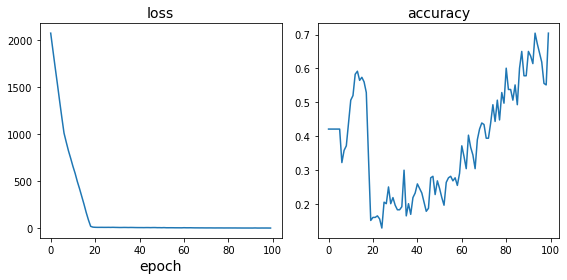

In [46]:
history = model.fit(penguin_train, epochs=100, verbose=0)

fig, ax = plt.subplots(1,2, figsize=(8,4), sharex=True)

ax[0].plot(history.history['loss'])
ax[1].plot(history.history['accuracy'])

ax[0].set_xlabel('epoch', fontsize=14)
ax[0].set_title('loss', fontsize=14)
ax[1].set_title('accuracy', fontsize=14)

fig.tight_layout()

### EarlyStopping - callbacks

- Fit과정에선 epoch을 조금씩 늘려나가거나 history를 이용해 적당한 epoch을 결정하게 된다. 또 다른 방법으로 loss나 metric에 별다른 개선이 없을때 학습을 강제로 종료시킬 수 있다.

```python
tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False )
```

- mode {'auto', 'min', 'max'}는 monitor하는 값의 개선방향을 지정<br>
- restore_best_weights = True 라면 monito하던 값이 가장 최적이었을때의 weight로 훈련을 종료


- [공식문서의 예제](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

```python
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
model.compile(tf.keras.optimizers.SGD(), loss='mse')
history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
                    epochs=10, batch_size=1, callbacks=[callback],
                    verbose=0)
```


- ModelCheckpoint와 같이 사용하여 모형을 저장한 후 사용한다.
```python
tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch', options=None, **kwargs )
```

- 훈련을 마친 모형 전체를 저장하여 사용하거나
```python
mc = ModelCheckpoint('best_model', monitor='val_acc', mode='max', save_best_only=True)
best_model = load_model('best_model')
```

- Weight만 저장하여 사용할 수 있다.
```python
ModelCheckpoint(..., save_weights_only=True)
model.load_weights(checkpoint_filepath)
```

## evaluate과 predict

- evaluate method는 훈련을 마친 모형을 사용하여 validation 혹은 test dataset을 검증하는데 사용한다.
- fit과 마찬가지로 loss와 metrics를 return한다.

```python
evaluate(
    x=None, y=None, batch_size=None, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False,
    return_dict=False, **kwargs
)
```

- predict는 예측에 사용

```python
predict(
    x, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10,
    workers=1, use_multiprocessing=False
)
```

In [47]:
loss, *accuracy = model.evaluate(penguin_test, verbose=0)
print('loss = ', loss, "accuracy =", accuracy)

y_pred = model.predict(penguin_test)
print()
print('predict: \n', y_pred[0,:])
print()
print('prediction: ', np.argmax(y_pred, 1))

loss =  0.7033188343048096 accuracy = [0.6818181872367859]

predict: 
 [0.53710186 0.21539886 0.24749924]

prediction:  [0 2 0 2 0 2 1 2 2 2 1 0 2 0 2 0 0 2 0 2 0 0 1 1 0 0 2 2 2 1 2 1 0 0 1 2 1
 2 0 0 0 0 2 2 0 0 1 0 0 2 0 1 2 0 0 1 0 0 1 1 1 1 2 0 0 2 0 2 0 1 0 1 1 2
 2 1 0 0 0 1 0 1 0 0 1 2 0 2 1 2 1 1 0 0 0 0 0 2 1 0 0 2 2 0 1 0 1 1 0 2]


### Feature scaling (normalization)

- Weight vector와 입력의 dot product는 선형함수이므로 이론적으로는 입력값의 rescaling 여부는 결과에 아무런 영향을 미치지 않는다.

- Decision boundary가 선형일 때는 [수렴](http://www.cs.columbia.edu/~mcollins/courses/6998-2012/notes/perc.converge.pdf)에 문제가 없지만 현실적으론 수렴하지 않거나 (때론 몇 천배 이상) 시간이 많이 걸릴 수 있다.

- Deep learning algorithm의 입력자료는 rescaling을 하길 권한다.
 - 어짜피 추정계수에 대한 해석은 고려대상이 아닌 경우가 대부분이므로 최소한 잃는 것은 없다.
 - [rescaling 방법들 비교](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)

## 예제: XOR



In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cluster_per_class, n_class = 3, 3
points_per_cluster = 32

xor_sample = xor(cluster_per_class=cluster_per_class, n_class=n_class)
xor_x, xor_y = xor_sample.data(points_per_cluster=points_per_cluster, 
                               cluster_std=0.3, random_state=42)

print('the number of classes: ', n_class)
print('sample size: ', cluster_per_class*n_class*points_per_cluster)

the number of classes:  3
sample size:  288


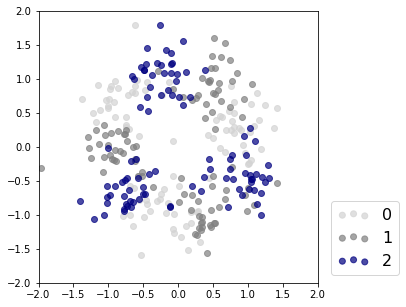

In [49]:
fig, ax = plt.subplots(figsize=(5, 5))

colors = ['lightgray', 'gray', 'navy']

for label in np.unique(xor_y):
    ax.scatter(xor_x[xor_y == label, 0], xor_x[xor_y == label, 1],
               label=label, alpha=.7, color=colors[label])

ax.legend(bbox_to_anchor=(1.02,0), loc="lower left", 
          scatterpoints = 3, prop={'size': 16});
ax.set_xlim([-2,2])
ax.set_ylim([-2,2]);

### Preprocess

1. 정규화
2. shuffle 및 batch_size=8로 나누어 훈련

In [50]:
x_train, x_test, y_train, y_test = train_test_split(xor_x, xor_y, test_size=0.33, random_state=42)

# Standardize the sample
scaler = StandardScaler()
scaler.fit(x_train)

x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)

# Dataset object
train_dataset_std = tf.data.Dataset.from_tensor_slices((x_train_std, y_train))
train_dataset_std = train_dataset_std.shuffle(buffer_size=10_000).batch(8)

test_dataset_std = tf.data.Dataset.from_tensor_slices((x_test_std, y_test)).batch(8)

### model

- 16 units 으로 구성된 3개의 layers를 갖는 MLP를 구성
- Hidden layer는 모두 ReLU, output layer는 softmax를 사용

In [51]:
inputs = tf.keras.Input(shape=(2,))
flatten = tf.keras.layers.Flatten()(inputs)
hidden1 = tf.keras.layers.Dense(units=16, activation='relu')(flatten)
hidden2 = tf.keras.layers.Dense(units=16, activation='relu')(hidden1)
hidden3 = tf.keras.layers.Dense(units=16, activation='relu')(hidden2)
outputs = tf.keras.layers.Dense(units=n_class, activation='softmax')(hidden3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 51        
Total params: 643
Trainable params: 643
Non-trainable params: 0
_______________________________________________________________

### compile

- Target value인 class는 intiger이므로 loss function은 'sparse_categorical_crossentropy'를 사용해보자.
- default optimizer는 'rmsprop'이고 learning_rate는 0.001이다. 여기선 default 값을 그대로 사용한다.

In [52]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), 
              metrics = ['accuracy'])

### Fit

- 2번의 epoch에서 loss 값이 감소하지 않으면 훈련을 중지한다.
- `save_weights_only=True`를 사용하면 weight만 저장할 수 있다.
- 현재 directory에 모형을 저장한다. 다시 사용할때는 다음과 같이 사용한다.

```python
tf.keras.models.load_model(filepath, compile=True)
```

In [53]:
tf.get_logger().setLevel('ERROR')

In [54]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

checkpoint_filepath = 'checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    save_best_only=True,
    verbose=0)

history = model.fit(train_dataset_std, epochs=20, 
                    callbacks=[early_stop_callback, model_checkpoint_callback], verbose=0);

### Evaluation

In [55]:
loss, *accuracy = model.evaluate(train_dataset_std, verbose=0)
print('in-sample perfomance: ', 'loss = ', loss, "accuracy =", accuracy)

loss, *accuracy = model.evaluate(test_dataset_std, verbose=0)
print('out-of-sample perfomance: ', 'loss = ', loss, "accuracy =", accuracy)

y_dist = model.predict(test_dataset_std)
y_pred = np.argmax(y_dist, 1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print(tf.math.confusion_matrix(y_test, y_pred))

in-sample perfomance:  loss =  0.7333053946495056 accuracy = [0.7760416865348816]
out-of-sample perfomance:  loss =  0.8754038214683533 accuracy = [0.625]
              precision    recall  f1-score   support

           0       0.61      0.70      0.65        33
           1       0.62      0.48      0.54        33
           2       0.66      0.70      0.68        30

    accuracy                           0.62        96
   macro avg       0.63      0.63      0.62        96
weighted avg       0.62      0.62      0.62        96

tf.Tensor(
[[23  5  5]
 [11 16  6]
 [ 4  5 21]], shape=(3, 3), dtype=int32)


## Tuning hyperparameters

- Neural network의 학습에 영향을 미치는 요인들이 많고, 요인들 간의 상호작용으로 인해 적당한 hyperparameter 값을 찾는 것이 쉽지 않다.


- 훈련을 하면서, 그리고 훈련을 마친 후 test dataset을 이용한 모형의 성과를 이용해
시행착오를 거치면서 최종적으로 사용할 hyperparameter의 값을 구하는 것이 일반적이다.

1. neuron과 hidden layer의 수
2. batch size와 epoch

- 다음은 DNN 전체 추정과정을 함수로 만들어 parameter의 효과를 비교하기 위해 사용한다.

In [56]:
import tensorflow as tf

def dnn(x, y, units = 2, hidden = 1, activation="relu", 
        initial="uniform", regularizer_para=(0, 0), drop_rate=0,
        optimizer='adam', loss="sparse_categorical_crossentropy",
        batch_size=None, epochs=10, verbose=0, validation_split=0,
        batch_normalization=False, learning_rate=0.001):
    
        # learning rate 은 최적화 algorithm에서 지정할 수 있다.
        # tf.keras.optimizers.Adam(learning_rate=0.001)
    
    regularizer = tf.keras.regularizers.L1L2(l1=regularizer_para[0],
                                             l2=regularizer_para[1])  # L1 + L2 penalties
    
    model = tf.keras.models.Sequential()
    
    for i in range(hidden):
        model.add(tf.keras.layers.Dense(units=units, input_dim = 2,
                                        activation=activation,
                                        kernel_initializer=initial,
                                        kernel_regularizer=regularizer))
        model.add(tf.keras.layers.Dropout(drop_rate))
        
    n_class = len(np.unique(y))

    model.add(tf.keras.layers.Dense(n_class, activation = "softmax"))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    hist = model.fit(x, y, batch_size=batch_size,
                     epochs=epochs, verbose=verbose,
                     validation_split = validation_split)                        
    
    return model, hist

### Neuron과 hidden layer의 수

- [The universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem#History)에 따르면 충분한 수의 neuron으로 이루어진 하나의 hidden layer로 구성한 network은 연속적인 함수를 근사할 수 있고, 2개의 hidden layer로 구성한다면 원하는 정확도로 근사할 수 있다. 
- 하지만 이 결과는 consistency에 국한되어 있어 efficiency나 학습의 난이도에 대해선 유용한 결과가 없다.


- Neuron
 - Unit의 수는 사용할 수 있는 linear decision boundary의 수와 관련이 있다.<br>
 - xor 문제에서 완벽한 분류에는 최소한 2개의 선이 필요하므로 unit의 수는 2개가 필요하다.


- Hidden layer
 - Hidden layer는 비선형 decision boundary를 구성하기 위해 필요하다.<br>
 - SVM의 kernel function과 유사하게 input data의 차원을 늘려 linear decision boundary로 분류가 가능하도록 도와준다.<br>
 - xor 문제에서 선형 decision boundary로는 완벽한 분리가 불가능하므로 하나 이상의 hidden layer가 필요하다.


- [Hidden layer의 역할](https://youtu.be/9uASADiYe_8)

In [57]:
tf.random.set_seed(42) # Sets the global random seed

epochs = [100, 200, 500]

for epoch in epochs:
    
    tf.keras.backend.clear_session()
    
    model, hist = dnn(xor_x, xor_y, units=2, epochs=epoch)
    loss, acc = model.evaluate(xor_x, xor_y)
    print('Test Accuracy: %.3f' % acc)
    print()

9/9 [==============================] - 0s 623us/step - loss: 1.0855 - accuracy: 0.4028
Test Accuracy: 0.403

9/9 [==============================] - 0s 686us/step - loss: 1.0961 - accuracy: 0.4618
Test Accuracy: 0.462

9/9 [==============================] - 0s 722us/step - loss: 1.0648 - accuracy: 0.3785
Test Accuracy: 0.378



### neuron의 수

- Neuron의 수가 너무 작으면 underfitting 문제가 발행할 수 있고, <br>
- 너무 많으면 overfitting 가능성이 많아진다. <br>
- 또한 training data가 클 경우 훈련에 감당하지 못할만큼 많은 시간이 걸릴 수 있다.


- 일반적인 규칙은 없지만 몇 가지 참고할만한 지침이 있다. [참고 사이트](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw)

- 각 layer에선<br>
- input layer나 ouput layer의 neuron 수 정도가 무난하다.<br>
- 가급적 input layer와 ouput layer 크기의 합을 넘지 않도록 하며,<br>
- 특별한 이유가 없다면 input layer의 두 배 이상은 사용하지 않는다.

- 다음은 전체 network에서 node의 수의 upperbound로 종종 제안되는 숫자이다.

$$ N_h = \frac{n}{\alpha (n_i+n_o)}, \quad \alpha = 2 \sim 10$$

- 하나의 hidden layer에 2, 4, 8 개 neuron을 사용한 network을 비교


- Curse of dimensionality는 여러가지 형태로 문제를 일으킨다.
- Unit 수가 지나치게 많으면 sparsity와 관련된 문제가 발생할 가능성이 많아 보인다.

In [58]:
def decision_boundary(x, model):
    
    # x is (n,2) array
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
    h = .02  # mesh grid size
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    pred = model.predict(np.c_[xx.ravel(), yy.ravel()])
    #Z = pred >= 1/2
    Z = np.argmax(pred, axis = 1)
    
    # decision regions
    Z = Z.reshape(xx.shape)
    
    return xx, yy, Z

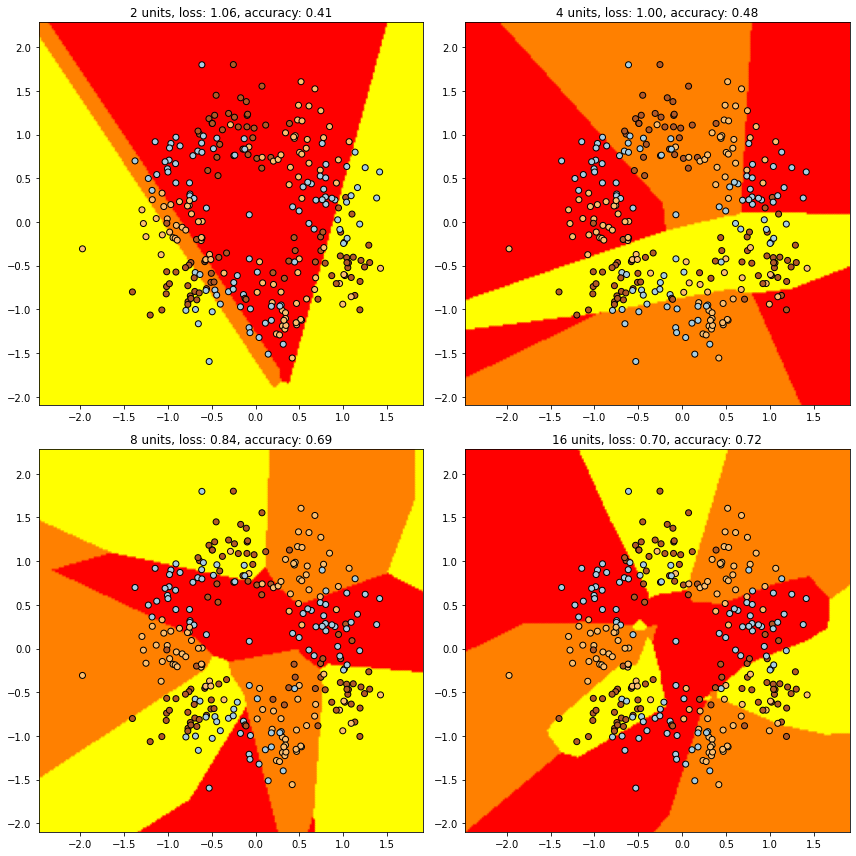

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax=ax.flatten()

units = [2,4,8,16]

for i, unit in enumerate(units):
    
    tf.keras.backend.clear_session()
    
    model, _= dnn(xor_x, xor_y, hidden=1, units=unit, epochs=500, verbose=0)
    loss, acc = model.evaluate(xor_x, xor_y, verbose=0)
    
    ax[i].pcolormesh(*decision_boundary(xor_x, model), shading="gouraud", cmap=plt.cm.autumn)
    ax[i].scatter(xor_x[:, 0], xor_x[:, 1], c = xor_y, edgecolors='k', cmap=plt.cm.Paired)
    ax[i].set_title(f"{unit} units, loss: {loss:.2f}, accuracy: {acc:.2f}", fontsize=12)
    
fig.tight_layout()

### hidden layer의 수

- Neuron의 수는 사용할 수 있는 linear decision boundar의 수, <br> 
- hidden layer의 수는 decision boundary의 비선형 정도로 이해하면 될 것 같다.


- 한편, 모든 종류의 neural network 모형에서 지적되는 layer의 수와 관련된 공통적인 문제는 vanishing gradient이다.
- 즉, Layer의 수가 많으면 backpropagation과정에서 input의 변화를 적절히 반영하지 못하는 문제가 발생한다.
- Layer의 수를 정할 때 overfitting과 같이 고려해야 하는 문제이다.


- 4개의 neuron으로 구성된 hidden layer를 1-4개로 구성한 network을 비교한다.

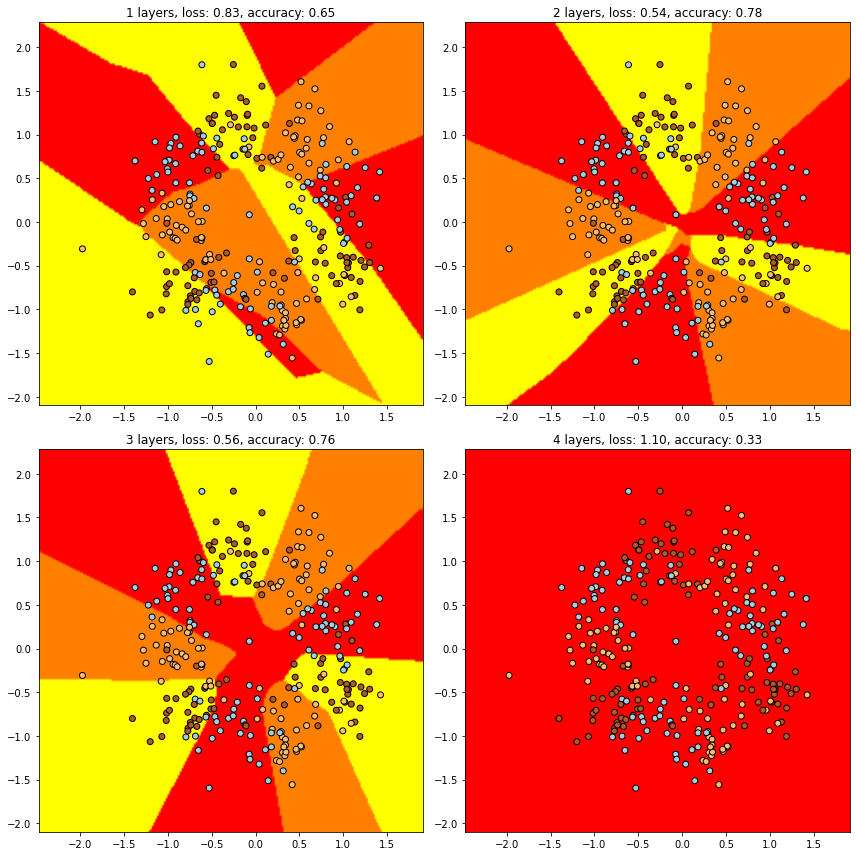

In [60]:
np.random.seed(42)
tf.random.set_seed(42)
    
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax=ax.flatten()

hidden_layers = [1,2,3,4]

for i, h in enumerate(hidden_layers):
    
    tf.keras.backend.clear_session()
    
    #model, _= dnn(xor_x, xor_y, units=8, hidden=h, epochs=500, verbose=0)
    model, _= dnn(xor_x, xor_y, units=8, hidden=h, epochs=1000, verbose=0)
    loss, acc = model.evaluate(xor_x, xor_y, verbose=0)
    
    ax[i].pcolormesh(*decision_boundary(xor_x, model), shading="gouraud", cmap=plt.cm.autumn)
    ax[i].scatter(xor_x[:, 0], xor_x[:, 1], c = xor_y, edgecolors='k', cmap=plt.cm.Paired)
    ax[i].set_title(f"{h} layers, loss: {loss:.2f}, accuracy: {acc:.2f}", fontsize=12)
    
plt.tight_layout()

- unit의 수가 증가하면 loss는 감소하는 경향이 있지만 
- hidden layer의 수를 증가시키면 loss가 커질 수도 있다.
hidden layer가 커지면서 추정할 모수의 수가 증가하므로 epoch을 같이 증가시킬 필요가 있다.


## Training Deep Neural Network

- 훈련과정에선 수렴여부/속도와 overfit 문제를 고려해야 한다.

1. convergence rate
 - kernel initialization
 - batch normalization


2. regularization
 - L2, L1 kernel_regularizer
 - Dropout, Alphadropout


3. Vanishing/Exploding Gradients
 - activation function (ReLU, SELU)
 - ResNet (CNN), LSTM (RNN)
 - Gradient clipping

### convergence rate

#### kernel initialization

- 모형을 훈련할 때 모든 neuron에 동일한 형태의 weight matrix를 적용하면 gradient가 동일해지므로 초기 backpropagation 과정에서 update의 효율성이 떨어진다. neuron들의 weight 초기값에는 어느 정도의 비대칭성이 필요하다.


- 또한 weight가 output의 분포(분산)에 미치는 직접적인 영향을 최소화하기 위해 모형에 따라 weight의 초기값을 조정하기도 한다.
Output의 분산은 feature의 수에 비례하므로 다음과 같은 방법을 많이 사용한다.

##### Lecun initializations: 

- 극한이 $\pm \sqrt{ \frac{1}{\text{input_dim}} }$인 균일분포 혹은 표준편자가 $\sqrt{ \frac{1}{\text{input_dim}} }$인 정규분포<br>


##### Xaiver or Glorot initializations: 

- sigmoid와 tanh와 같은 비선형함수에선 효과적이비만 ReLU에선 weight의 대부분이 0이 되어버리는 현상

- 극한이 $\pm \sqrt{ \frac{6}{\text{input_dim}+\text{output_dim}}}$인 균일분포 혹은 표준편자가 $\sqrt{ \frac{2}{\text{input_dim}+\text{output_dim}} }$인 정규분포<br>

##### He initializations

- ReLU에서 Xaiver 방법의 문제점을 해결하기 위해 고안

-  극한이 $\sqrt{ \pm \frac{6}{\text{input_dim}} }$인 균일분포 혹은 
표준편자가 $\sqrt{ \frac{2}{\text{input_dim}} }$인 정규분포


<p style="color:navy; font-size:1.25em; font-weight:bolder"> Weight 

Weight의 크기는 해당 layer의 input shape(직전 layer의 output)과 output shape(unit 수) 에 의해 기계적으로 결정된다.<br>
input_dim (feature의 수)가 column의 수를 결정하며, unit당 row가 하나씩 추가된다.<br>

$$ \underbrace{\mathbf{x}}_{(\text{None}, K)} \underbrace{\mathbf{w}}_{(K, \text{n_units})} 
+ \underbrace{b}_{\text{(n_units,)}}, \quad  \mathbf{w}^\intercal \mathbf{x}_i + b$$

앞의 xor 예에서 2개의 feature가 입력되므로 weight는 $2\times \text{n_units}$ 행렬이 된다.


- parameter의 수는 bias를 포함하므로 dense network에서 각 unit에서 추정해야 하는 parameter의 수는<br>
$\text{number of parameters} = \text{output size} \times \text{(input_dim + 1)}$<br>


- `model.get_weights()` method는 모든 layer의 weight와 bias를 순서대로 정리한 list를 return<br>
4개의 hidden layer가 있다면 8개의 계수 array를 포함하는 list가 된다.

$$ [\mathbf{w}_1], b_1, \cdots, [\mathbf{w}_n], b_n $$

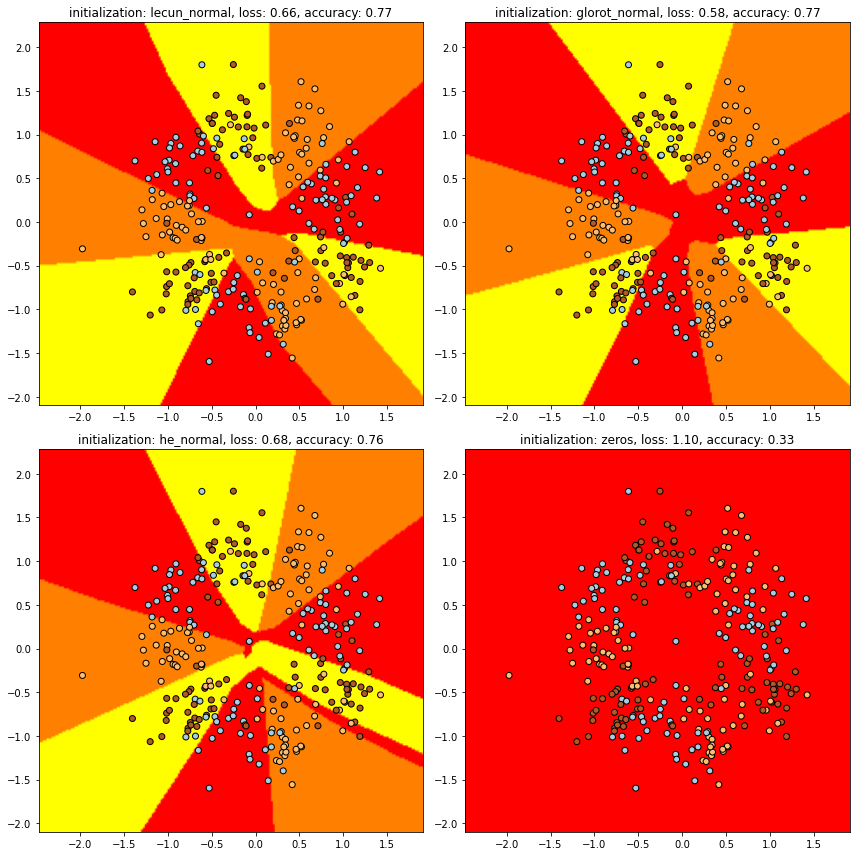

In [61]:
import tensorflow as tf
np.random.seed(seed=42)

initial_weights = ['lecun_normal', 'glorot_normal', 'he_normal', 'zeros']
#initial_weights = ['lecun_uniform', 'glorot_uniform', 'he_uniform', 'zeros']

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax=ax.flatten()

for i, w in enumerate(initial_weights):
    
    tf.keras.backend.clear_session()
    
    model, _= dnn(xor_x, xor_y, units=8, hidden=2, initial = w,
                  epochs=200, verbose=0)
    loss, acc = model.evaluate(xor_x, xor_y, verbose=0)
    
    ax[i].pcolormesh(*decision_boundary(xor_x, model), shading="gouraud", cmap=plt.cm.autumn)
    ax[i].scatter(xor_x[:, 0], xor_x[:, 1], c = xor_y, edgecolors='k', cmap=plt.cm.Paired)
    ax[i].set_title(f"initialization: {w}, loss: {loss:.2f}, accuracy: {acc:.2f}", fontsize=12)    

plt.tight_layout()

#### Batch normalization

- Hidden layer의 input을 정규화

- 여러 자료에서 iteration 수와 validation error를 감소시키는 효과

- layer마다 2개의 모수가 추가되고 정규화를 위한 계산이 추가되어 훈련시간이 증가

### regularization

#### L2, L1 regularization

- loss가 아주 큰 값을 가지면 weight가 작아져 훈련이 제대로 되지 않을 수 있다.

```python
from tf.keras import regularizers
tf.keras.layers.Dense(3, kernel_regularizer=regularizers.L1L2(l1=0.0, l2=0.01)
tf.keras.layers.Dense(3, kernel_regularizer='l1_l2') # default l1=0.01, l2=0.01
```

#### Dropout, Alphadropout

- 가장 간단하고 나름 효과적인 regularization 방법으로 가장 흔히 사용하는 regularization 방법이다.
- 하지만 모형에 따라 효과가 다르게 나타날 수 있다. [참고](https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html)

### Vanishing/Exploding Gradients

- Layer의 수가 증가하면서 chain rule의 특성으로 인해 gradient가 작아지는 경향이 있다.
- 특히 앞단에 위치한 layer의 update는 상대적으로 늦어지게 되고 이러한 불균형으로 인해 바람직한 결과를 얻기 어렵게 된다.

#### Activation funciton

- Hidden layer의 neuron의 경우 과거 sigmoid를 주로 사용했지만 속도와 satuation 문제로 최근엔 ReLU를 주로 사용한다.
- 하지만 gradient가 0이 되어 버리면 관련 neuron의 weight가 모두 0이 되어버리는 문제가 발생 (dying ReLUs)


- 다양한 변형이 있지만 대부분의 자료에서 ReLU와 He initializer가 효율적인 선택으로 알려져 있다.
- SELU와 Lecun initializer는 vanishing gradient 문제를 극적으로 줄여준다.
- leaky ReLU(LeakyReLU), randomized leaky ReLU(RReLU), parametric leaky ReLU (PReLU), exponential linear unit (ELU)

#### RNN, CNN

- Network이 깊어질수록 performance가 나빠지지 않는 것이 '상식'같이 보이지만 vanishing gradient 문제로 hidden layer가 지나치게 많아지면 performance가 나빠지는 것이 일반적이다.
- 특히 RNN의 경우 hidden layer의 수는 별 선택의 여지가 없으므로 심각한 문제이다.


#### Gradient clipping

- Gradient가 지정한 범위를 벗어나지 못하도록 제약을 가한다.

```python

from keras.optimizers import SGD

opt = SGD(lr=0.01, momentum=0.9, clipnorm=1.0)
opt = SGD(lr=0.01, momentum=0.9, clipvalue=0.5)
```

### pretrained layer 사용

- Training에 사용할 표본이 충분히 크지 않을 때 유사한 자료를 이용한 훈련된 모형이 있다면 사전에 구한 layer들을 재활용할 수 있다.
- 재활용하는 layer들은 weight를 update하지 않으며, 필요에 따라 후단부의 일부 weight를 학습하기도 한다.
- Encoder-decoder 모형에서 흔히 사용하는 방법이다.

In [62]:
# clone trained model without output layer
model_clone = tf.keras.models.Sequential(model.layers[:-1])
model_clone = tf.keras.models.clone_model(model_clone)

# Copy weights manually since clone_model doesn't clone weights
#model_clone.set_weights(model.get_weights())

# Build the cloned model using same input shape as original model
model_clone.build(model.layers[0].input_shape)

# Add output layer
model_clone.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# Freezing the lower layers
for layer in model_clone.layers[:-1]:
    layer.trainable = False

model_clone.compile(loss="binary_crossentropy", optimizer="sgd")
#model_clone.fit(...)



모든 layer를 freeze한 후 performance를 봐가면서 마지막 layer 부터 한두 개씩 훈련을 시켜나간다.
표본이 충분하지 않은 경우 performance가 좋아지지 않는다면 layer를 pretrained layer를 하나씩 제거히 본다.
표본이 충분히 크다면 layer를 update해보거나 추가해 본다.

In [63]:
# Unfreeze reused layers
for layer in model_clone.layers[-2:-1]:
    layer.trainable = True

# Reduce learning rate to prevent wrecking reused weights
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
model_clone.compile(loss="binary_crossentropy", optimizer=optimizer)

### Overfitting and Regularization

Machine learning algorithm의 기능과 유사하게 feature의 영향을 일괄적으로 감소시키거나
일부 neuron을 비활성화시켜 feature의 변화에 덜 민감하게 반응하도록 할 수 있다.

훈련을 충분히 하기 위해 epoch을 크게 할 경우 overfitting 문제를 피하기 위해 '반드시' 포함시켜야 한다.

1. Early stopping
1. L2 regulaization
2. L1 regularization
3. Dropout normally with the rate of 0.5
5. max-norm regularization

## Cross validation

- Cross validation은 fit method의 option으로 하나의 epoch마다 training data의 일부를 평가용으로 남겨두었다가 해당 epoch의 훈련이 끝난 후 모형의 훈련성과를 평가하는 out-of-sample testing 방법이다.

- 보통 training data의 20%, 1/3 정도를 평가 목적으로 사용한다.

### simple hold-out split

```python
model.fit(x, y, validation_split=0.2, epochs=10, batch_size=10)
```

- Verbose output에서 training dataset과 validation dataset의 손실함수와 평가지표의 값을 확인할 수 있다.

- Test data를 validation에 사용하면 하나의 epoch을 마칠 때마다 test set에 대한 모형의 성과를 확인할 수 있다.

### customized validation sample

```python
model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=10, batch_size=10)
```

- validation과 evaluation이 중요해진다.

<p style="color:navy; font-size:1.25em; font-weight:bolder"> Cross validation

Training dataset과 test dataset을 구분하지 않고 표본 전체를 k개로 나누어 (k-1)개의 folds로 훈련시키고 나머지 한 fold를 이용해 훈련된 모형을 평가한다.

K-fold cross validation은 `tf.keras`에서 지원을 하지 않는다. Neural network에 적용하기 위해서는 직접 code를 작성하여야 한다. [참고 사이트](https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/)

<p style="color:navy; font-size:1.em; font-weight:bolder"> k-fold cross-validation

```python
cv = sklearn.model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
specify a model
scores = sklearn.model_selection.cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
```

<p style="color:navy; font-size:1.em; font-weight:bolder"> stratified k-fold cross-validation

분류모형에 적용할 때는 fold마다 class의 비율을 비슷하게 만들 필요가 있다.

```python
skf = sklearn.model_selection.StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)
```

## 훈련을 마친 모형 저장 방법

```python
my_model.fit(...)
```

fitting을 마친 후 현재 working directory에 훈련을 마친 모델을 저장할 폴더를 생성한다.

```python
!mkdir -p saved_model
my_model.save('saved_model/my_model') 
```
`my_model` 폴더 안에는 assets, variables 두 개의 폴더와 saved_model.pb 파일이 저장된다.

```python
model = tf.keras.models.load_model('saved_model/my_model')
```
으로 동일한 모형을 탑재할 수 있다.

```python
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(x_test)))
```


Weight 저장:
model을 저장하는 경우 동일한 결과가 나온다는 보장이 없다.
이때는 추정한 weight를 같이 저장해서 사용하는 것이 안전하다.

```python
# Save the weights
model.save_weights('saved_model/my_model')

# load the model instance
model = tf.keras.models.load_model('saved_model/my_model')

# Restore the weights
model.load_weights('saved_model/my_model')
```